# **Regression Rumble NDC 2025**

Author: Harry Mardika

## Setup & Configuration 

In [1]:
import os
import gc
import joblib
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import randint, uniform, norm, loguniform
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures, QuantileTransformer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import mutual_info_regression

In [2]:
# -- Path File  --
TRAIN_PATH = 'data/regression-rumble-ndc-2025/train.csv'
TEST_PATH = 'data/regression-rumble-ndc-2025/test.csv'
SUBMISSION_PATH = 'data/regression-rumble-ndc-2025/sample_submission.csv'

# --- Konstanta ---
SEED = 42
TARGET = 'hydrostatic_pressure'
SEED = 42
N_SPLITS = 10

# -- Konfigurasi Dasar --
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

np.random.seed(SEED)

## Data Preparation

In [3]:
df_train = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

In [4]:
df = pd.concat([df_train, df_test], ignore_index=True, sort=False)
df = df.sort_values(by='measurement_id')
df = df.reset_index(drop=True)

In [5]:
df.dropna(inplace=True, how='all')

In [6]:
df

,measurement_id,depth_reading_time,water_temperature_50m,salinity_50m,oxygen_saturation_50m,perceived_water_density,sediment_deposition,seafloor_pressure,plankton_density,microplankton_density,mesoplankton_density,macroplankton_density,dissolved_gas_pressure,current_velocity_near_surface,current_velocity_deep,current_direction_near_surface,current_direction_deep,current_turbulence,sediment_temperature_0_to_10cm,sediment_temperature_10_to_30cm,sediment_temperature_30_to_100cm,sediment_temperature_100_to_250cm,sediment_porosity_0_to_10cm,sediment_porosity_10_to_30cm,sediment_porosity_30_to_100cm,sediment_porosity_100_to_250cm,blue_light_penetration,downwelling_light,scattered_light,perpendicular_light_intensity,thermal_emissions,is_photic_zone,photoperiod_intensity,chlorophyll_a_concentration (mg m-3),nitrate_concentration (µmol L-1),phosphate_concentration (µmol L-1),silicate_concentration (µmol L-1),total_alkalinity (µmol kg-1),dissolved_inorganic_carbon (µmol kg-1),pH,partial_pressure_CO2 (µatm),aragonite_saturation_state,sea_surface_height_anomaly (cm),significant_wave_height (m),bottom_current_shear_stress (Pa),sound_speed_water (m s-1),acoustic_backscatter_intensity (dB),turbidity (NTU),light_attenuation_coefficient_Kd (m⁻¹),bioluminescence_intensity (photons cm-2 s-1),Brunt_Vaisala_frequency_squared (s-2),mixed_layer_depth (m),hydrostatic_pressure,total_light_exposure
0,1,2022-01-01 00:00:00,NaN,12.7,"20,7","25,7","0,1",0.9872,52.0,3.0,32.0,NaN,NaN,3.975,8.175,298.0,278.0,"16,6",296.95,NaN,298.65,298.55,"0,272",NaN,"0,269","0,323",0.0,0.0,0.0,NaN,0,0.0,0.0,3.224434,4.327586,0.245655,4.630902,2179.063110,NaN,NaN,NaN,NaN,-1.451344,0.959121,NaN,1496.157771,-61.838223,5.826377,0.716677,5.253051e+06,0.000014,55.703523,NaN,0.0
1,2,2022-01-01 01:00:00,295.35,NaN,"20,3","25,5",NaN,0.9867,NaN,NaN,NaN,NaN,"0,29",3.975,9.525,298.0,295.0,"8,3",NaN,298.45,298.65,298.55,"0,271","0,278","0,269",NaN,0.0,NaN,0.0,0,0,0.0,0.0,3.577219,NaN,0.258023,3.147517,2163.040961,2069.428976,8.138739,NaN,2.947761,3.325856,1.062183,0.017627,NaN,-65.513550,5.883116,0.773086,2.032279e+07,NaN,45.398676,1.0109,NaN
2,3,2022-01-01 02:00:00,NaN,13.9,"20,2","25,4",0,0.9858,42.0,7.0,10.0,100.0,"0,37",NaN,12.600,NaN,315.0,NaN,NaN,298.25,298.65,298.55,"0,271","0,278","0,269",NaN,0.0,0.0,0.0,0,0,0.0,0.0,2.907752,4.450997,0.278808,4.499263,NaN,NaN,NaN,NaN,NaN,NaN,1.500959,NaN,NaN,-61.667442,5.042899,0.631707,NaN,0.000011,38.188092,1.0100,NaN
3,4,2022-01-01 03:00:00,295.65,14.2,"20,1","25,1",0,0.9858,43.0,8.0,9.0,100.0,"0,38",NaN,NaN,320.0,313.0,"15,1",296.25,298.15,298.65,298.55,"0,27",NaN,"0,268","0,323",0.0,NaN,0.0,0,0,0.0,0.0,3.235939,NaN,0.213943,4.348097,2228.133421,NaN,8.169724,378.894643,2.804115,3.744792,1.744662,0.069485,1498.294603,-62.421067,5.562290,NaN,1.999648e+06,0.000068,50.566638,NaN,0.0
4,5,2022-01-01 04:00:00,295.85,14.8,"19,9","25,6",0,0.9857,NaN,13.0,NaN,100.0,"0,43",4.800,12.075,308.0,312.0,18,296.15,297.95,298.65,298.55,"0,27",NaN,NaN,"0,323",0.0,0.0,0.0,0,NaN,0.0,0.0,NaN,3.098552,0.200462,3.412068,2199.583807,2065.493823,8.267341,352.226746,NaN,5.458362,1.147936,0.021427,1503.777335,NaN,5.733180,0.655675,4.292172e+06,0.000030,45.305633,1.0098,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21883,21884,2024-06-30 19:00:00,297.55,12.7,NaN,"29,1",0.0,0.9873,75.0,NaN,3.0,NaN,"0,26",4.200,NaN,NaN,151.0,NaN,299.25,299.55,298.85,299.15,"0,226",NaN,NaN,"0,271",0.0,0.0,0.0,0,0,0.0,0.0,0.010000,6.559980,0.441440,NaN,2175.701020,NaN,8.072257,408.761703,2.549776,1.858846,0.632416,0.002500,1523.511909,NaN,0.940452,0.129149,NaN,0.000176,52.791717,NaN,0.0
21884,21885,NaN,297.25,12.1,"22,9",29,0.0,0.9880,76.0,45.0,10.0,100.0,"0,22",3.075,4.425,NaN,NaN,"7,2",299.05,299.35,298.85,299.15,"0,232","0,21","0,181","0,271",0.0,0.0,0.0,NaN,0,0.0,0.0,0.091201,6.007422,0.409241,5.641196,2215.1098

### Check information

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21888 entries, 0 to 21887
Data columns (total 54 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   measurement_id                                21888 non-null  int64  
 1   depth_reading_time                            18570 non-null  object 
 2   water_temperature_50m                         10375 non-null  float64
 3   salinity_50m                                  17110 non-null  float64
 4   oxygen_saturation_50m                         17651 non-null  object 
 5   perceived_water_density                       20481 non-null  object 
 6   sediment_deposition                           14757 non-null  object 
 7   seafloor_pressure                             17455 non-null  float64
 8   plankton_density                              14552 non-null  float64
 9   microplankton_density                         15736 non-null 

### Check missing value

In [8]:
df.isnull().sum()

measurement_id                                      0
depth_reading_time                               3318
water_temperature_50m                           11513
salinity_50m                                     4778
oxygen_saturation_50m                            4237
perceived_water_density                          1407
sediment_deposition                              7131
seafloor_pressure                                4433
plankton_density                                 7336
microplankton_density                            6152
mesoplankton_density                             5530
macroplankton_density                            3837
dissolved_gas_pressure                           3736
current_velocity_near_surface                    7827
current_velocity_deep                            4118
current_direction_near_surface                   4619
current_direction_deep                           4768
current_turbulence                               6849
sediment_temperature_0_to_10

In [9]:
# 1. First, let's examine the missing value patterns
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.concat([missing_values, missing_percent], axis=1, keys=['Missing Count', 'Missing Percent'])
print("Columns with highest missing percentages:")
print(missing_df[missing_df['Missing Count'] > 0].head(20))

Columns with highest missing percentages:
                                        Missing Count  Missing Percent
total_light_exposure                            16197        73.999452
aragonite_saturation_state                      12100        55.281433
pH                                              12031        54.966192
water_temperature_50m                           11513        52.599598
dissolved_inorganic_carbon (µmol kg-1)          11292        51.589912
partial_pressure_CO2 (µatm)                     11142        50.904605
current_velocity_near_surface                    7827        35.759320
plankton_density                                 7336        33.516082
sediment_deposition                              7131        32.579496
current_turbulence                               6849        31.291118
hydrostatic_pressure                             6567        30.002741
microplankton_density                            6152        28.106725
sediment_porosity_30_to_100cm      

In [10]:
missing_df[missing_df['Missing Count'] > 0].tail(20)

,Missing Count,Missing Percent
macroplankton_density,3837,17.530154
dissolved_gas_pressure,3736,17.068713
depth_reading_time,3318,15.158991
sediment_porosity_100_to_250cm,3260,14.894006
sediment_temperature_10_to_30cm,3088,14.108187
is_photic_zone,3004,13.724415
acoustic_backscatter_intensity (dB),2971,13.573648
sound_speed_water (m s-1),2528,11.549708
perpendicular_light_intensity,2478,11.321272
sea_surface_height_anomaly (cm),2385,10.896382


### Check duplicate data

In [11]:
# Check for duplicate rows in the dataframe
duplicate_rows = df_train.duplicated().sum()
print(f"Total number of duplicate rows: {duplicate_rows}")

# Check for duplicate measurement_id values
duplicate_ids = df_train['measurement_id'].duplicated().sum()
print(f"Total number of duplicate measurement IDs: {duplicate_ids}")

# If there are duplicates, examine them
if duplicate_ids > 0:
    print("\nDuplicate measurement IDs:")
    duplicate_id_values = df_train[df_train['measurement_id'].duplicated(keep=False)].sort_values('measurement_id')
    print(duplicate_id_values['measurement_id'].value_counts().head(10))

Total number of duplicate rows: 0
Total number of duplicate measurement IDs: 0


### Check data type

In [12]:
# Get all columns with object data type
object_columns = df.select_dtypes(include=['object']).columns

# Display a sample of each object column to examine their content
for column in object_columns:
    print(f"\n===== Column: {column} =====")
    print(f"Total values: {df[column].count()} non-null out of {len(df)} entries")
    print(f"Unique values: {df[column].nunique()}")
    print("Sample values:")
    print(df[column].sample(5).values)
    
    # Check if the column might contain numeric values in string format
    try:
        # Try to convert a sample to float to see if it's numeric data stored as string
        sample = df[column].dropna().sample(10).str.replace(',', '.').astype(float)
        print("This column appears to contain numeric values stored as strings (commas instead of decimal points)")
    except:
        # If conversion fails, likely not numeric data or different format
        pass


===== Column: depth_reading_time =====
Total values: 18570 non-null out of 21888 entries
Unique values: 18570
Sample values:
['2022-10-23 21:00:00' '2023-09-15 06:00:00' '2023-11-19 06:00:00'
 '2023-04-01 21:00:00' '2023-06-09 23:00:00']

===== Column: oxygen_saturation_50m =====
Total values: 17651 non-null out of 21888 entries
Unique values: 126
Sample values:
['22,1' '22,6' nan nan nan]
This column appears to contain numeric values stored as strings (commas instead of decimal points)

===== Column: perceived_water_density =====
Total values: 20481 non-null out of 21888 entries
Unique values: 205
Sample values:
['35,4' '21,5' '36,2' '28,2' '31,2']
This column appears to contain numeric values stored as strings (commas instead of decimal points)

===== Column: sediment_deposition =====
Total values: 14757 non-null out of 21888 entries
Unique values: 216
Sample values:
['0.0' '0,1' nan '1,6' nan]
This column appears to contain numeric values stored as strings (commas instead of decima

## Data Handling

### Fill missing datetime

In [13]:
# 1. Pastikan Tipe Data Benar
df['depth_reading_time'] = pd.to_datetime(df['depth_reading_time'], errors='coerce')

# Cek jumlah missing value sebelum diisi
print("Jumlah missing values SEBELUM diisi:")
print(df['depth_reading_time'].isna().sum())
print("-" * 30)

# 2. Identifikasi NaN Asli
is_nan = df['depth_reading_time'].isna()

# 3. Forward Fill untuk mendapatkan 'base time'
base_time = df['depth_reading_time'].ffill()

# 4. Buat Grup NaN Berurutan (dan non-NaN)
group_id = is_nan.ne(is_nan.shift()).cumsum()

# 5. Hitung Penambah Jam untuk setiap NaN dalam grupnya
hours_to_add = df.groupby(group_id).cumcount() + 1

# 6. Buat Timedelta (penambah waktu) hanya untuk baris yang aslinya NaN
time_delta = pd.to_timedelta(hours_to_add[is_nan], unit='h')

# 7. Tambahkan Timedelta ke 'base_time' hanya untuk baris yang aslinya NaN
filled_values = base_time[is_nan] + time_delta

# 8. Update DataFrame Asli
df.loc[is_nan, 'depth_reading_time'] = filled_values

# Cek jumlah missing value setelah diisi
print("\nJumlah missing values SETELAH diisi:")
print(df['depth_reading_time'].isna().sum())
print("-" * 30)

Jumlah missing values SEBELUM diisi:
3318
------------------------------

Jumlah missing values SETELAH diisi:
0
------------------------------


In [14]:
df.head()

,measurement_id,depth_reading_time,water_temperature_50m,salinity_50m,oxygen_saturation_50m,perceived_water_density,sediment_deposition,seafloor_pressure,plankton_density,microplankton_density,mesoplankton_density,macroplankton_density,dissolved_gas_pressure,current_velocity_near_surface,current_velocity_deep,current_direction_near_surface,current_direction_deep,current_turbulence,sediment_temperature_0_to_10cm,sediment_temperature_10_to_30cm,sediment_temperature_30_to_100cm,sediment_temperature_100_to_250cm,sediment_porosity_0_to_10cm,sediment_porosity_10_to_30cm,sediment_porosity_30_to_100cm,sediment_porosity_100_to_250cm,blue_light_penetration,downwelling_light,scattered_light,perpendicular_light_intensity,thermal_emissions,is_photic_zone,photoperiod_intensity,chlorophyll_a_concentration (mg m-3),nitrate_concentration (µmol L-1),phosphate_concentration (µmol L-1),silicate_concentration (µmol L-1),total_alkalinity (µmol kg-1),dissolved_inorganic_carbon (µmol kg-1),pH,partial_pressure_CO2 (µatm),aragonite_saturation_state,sea_surface_height_anomaly (cm),significant_wave_height (m),bottom_current_shear_stress (Pa),sound_speed_water (m s-1),acoustic_backscatter_intensity (dB),turbidity (NTU),light_attenuation_coefficient_Kd (m⁻¹),bioluminescence_intensity (photons cm-2 s-1),Brunt_Vaisala_frequency_squared (s-2),mixed_layer_depth (m),hydrostatic_pressure,total_light_exposure
0,1,2022-01-01 00:00:00,NaN,12.7,"20,7","25,7","0,1",0.9872,52.0,3.0,32.0,NaN,NaN,3.975,8.175,298.0,278.0,"16,6",296.95,NaN,298.65,298.55,"0,272",NaN,"0,269","0,323",0.0,0.0,0.0,NaN,0,0.0,0.0,3.224434,4.327586,0.245655,4.630902,2179.063110,NaN,NaN,NaN,NaN,-1.451344,0.959121,NaN,1496.157771,-61.838223,5.826377,0.716677,5.253051e+06,0.000014,55.703523,NaN,0.0
1,2,2022-01-01 01:00:00,295.35,NaN,"20,3","25,5",NaN,0.9867,NaN,NaN,NaN,NaN,"0,29",3.975,9.525,298.0,295.0,"8,3",NaN,298.45,298.65,298.55,"0,271","0,278","0,269",NaN,0.0,NaN,0.0,0,0,0.0,0.0,3.577219,NaN,0.258023,3.147517,2163.040961,2069.428976,8.138739,NaN,2.947761,3.325856,1.062183,0.017627,NaN,-65.513550,5.883116,0.773086,2.032279e+07,NaN,45.398676,1.0109,NaN
2,3,2022-01-01 02:00:00,NaN,13.9,"20,2","25,4",0,0.9858,42.0,7.0,10.0,100.0,"0,37",NaN,12.600,NaN,315.0,NaN,NaN,298.25,298.65,298.55,"0,271","0,278","0,269",NaN,0.0,0.0,0.0,0,0,0.0,0.0,2.907752,4.450997,0.278808,4.499263,NaN,NaN,NaN,NaN,NaN,NaN,1.500959,NaN,NaN,-61.667442,5.042899,0.631707,NaN,0.000011,38.188092,1.0100,NaN
3,4,2022-01-01 03:00:00,295.65,14.2,"20,1","25,1",0,0.9858,43.0,8.0,9.0,100.0,"0,38",NaN,NaN,320.0,313.0,"15,1",296.25,298.15,298.65,298.55,"0,27",NaN,"0,268","0,323",0.0,NaN,0.0,0,0,0.0,0.0,3.235939,NaN,0.213943,4.348097,2228.133421,NaN,8.169724,378.894643,2.804115,3.744792,1.744662,0.069485,1498.294603,-62.421067,5.562290,NaN,1.999648e+06,0.000068,50.566638,NaN,0.0
4,5,2022-01-01 04:00:00,295.85,14.8,"19,9","25,6",0,0.9857,NaN,13.0,NaN,100.0,"0,43",4.800,12.075,308.0,312.0,18,296.15,297.95,298.65,298.55,"0,27",NaN,NaN,"0,323",0.0,0.0,0.0,0,NaN,0.0,0.0,NaN,3.098552,0.200462,3.412068,2199.583807,2065.493823,8.267341,352.226746,NaN,5.458362,1.147936,0.021427,1503.777335,NaN,5.733180,0.655675,4.292172e+06,0.000030,45.305633,1.0098,NaN


In [15]:
# Check distribution of dates
print("\nDate range for depth_reading_time in training data:")
print(f"Earliest date: {df['depth_reading_time'].min()}")
print(f"Latest date: {df['depth_reading_time'].max()}")


Date range for depth_reading_time in training data:
Earliest date: 2022-01-01 00:00:00
Latest date: 2024-06-30 23:00:00


### Add datetime features

In [16]:
# Extract additional datetime features that might be useful for modeling
df['year'] = df['depth_reading_time'].dt.year
df['month'] = df['depth_reading_time'].dt.month
df['day'] = df['depth_reading_time'].dt.day
df['hour'] = df['depth_reading_time'].dt.hour
df['dayofweek'] = df['depth_reading_time'].dt.dayofweek

print("\nNew datetime features added to the dataframes")


New datetime features added to the dataframes


In [17]:
df[['year', 'month', 'day', 'hour', 'dayofweek']].head()

,year,month,day,hour,dayofweek
0,2022,1,1,0,5
1,2022,1,1,1,5
2,2022,1,1,2,5
3,2022,1,1,3,5
4,2022,1,1,4,5


### Convert type of data

In [18]:
# Process all object columns to convert to float where possible
for column in object_columns:
    if column == 'depth_reading_time' or column == 'measurement_id':
        # Skip timestamp column
        continue
    
    try:
        # Replace comma with dot for decimal point
        df[column] = df[column].str.replace(',', '.').astype(float)
        print(f"Converted {column} to float")
        
    except Exception as e:
        print(f"Could not convert {column}: {e}")

# Check the result for thermal_emissions specifically
print("\nThermal emissions data type:", df['thermal_emissions'].dtype)

Converted oxygen_saturation_50m to float
Converted perceived_water_density to float
Converted sediment_deposition to float
Converted dissolved_gas_pressure to float
Converted current_turbulence to float
Converted sediment_porosity_0_to_10cm to float
Converted sediment_porosity_10_to_30cm to float
Converted sediment_porosity_30_to_100cm to float
Converted sediment_porosity_100_to_250cm to float
Converted perpendicular_light_intensity to float
Converted thermal_emissions to float

Thermal emissions data type: float64


In [19]:
# First, copy the blue_light_penetration values to total_light_exposure
# where total_light_exposure is missing
df.loc[df['total_light_exposure'].isna(), 'total_light_exposure'] = df.loc[df['total_light_exposure'].isna(), 'blue_light_penetration']

In [21]:
df

,measurement_id,depth_reading_time,water_temperature_50m,salinity_50m,oxygen_saturation_50m,perceived_water_density,sediment_deposition,seafloor_pressure,plankton_density,microplankton_density,mesoplankton_density,macroplankton_density,dissolved_gas_pressure,current_velocity_near_surface,current_velocity_deep,current_direction_near_surface,current_direction_deep,current_turbulence,sediment_temperature_0_to_10cm,sediment_temperature_10_to_30cm,sediment_temperature_30_to_100cm,sediment_temperature_100_to_250cm,sediment_porosity_0_to_10cm,sediment_porosity_10_to_30cm,sediment_porosity_30_to_100cm,sediment_porosity_100_to_250cm,blue_light_penetration,downwelling_light,scattered_light,perpendicular_light_intensity,thermal_emissions,is_photic_zone,photoperiod_intensity,chlorophyll_a_concentration (mg m-3),nitrate_concentration (µmol L-1),phosphate_concentration (µmol L-1),silicate_concentration (µmol L-1),total_alkalinity (µmol kg-1),dissolved_inorganic_carbon (µmol kg-1),pH,partial_pressure_CO2 (µatm),aragonite_saturation_state,sea_surface_height_anomaly (cm),significant_wave_height (m),bottom_current_shear_stress (Pa),sound_speed_water (m s-1),acoustic_backscatter_intensity (dB),turbidity (NTU),light_attenuation_coefficient_Kd (m⁻¹),bioluminescence_intensity (photons cm-2 s-1),Brunt_Vaisala_frequency_squared (s-2),mixed_layer_depth (m),hydrostatic_pressure,total_light_exposure,year,month,day,hour,dayofweek
0,1,2022-01-01 00:00:00,NaN,12.7,20.7,25.7,0.1,0.9872,52.0,3.0,32.0,NaN,NaN,3.975,8.175,298.0,278.0,16.6,296.95,NaN,298.65,298.55,0.272,NaN,0.269,0.323,0.0,0.0,0.0,NaN,0.0,0.0,0.0,3.224434,4.327586,0.245655,4.630902,2179.063110,NaN,NaN,NaN,NaN,-1.451344,0.959121,NaN,1496.157771,-61.838223,5.826377,0.716677,5.253051e+06,0.000014,55.703523,NaN,0.0,2022,1,1,0,5
1,2,2022-01-01 01:00:00,295.35,NaN,20.3,25.5,NaN,0.9867,NaN,NaN,NaN,NaN,0.29,3.975,9.525,298.0,295.0,8.3,NaN,298.45,298.65,298.55,0.271,0.278,0.269,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,3.577219,NaN,0.258023,3.147517,2163.040961,2069.428976,8.138739,NaN,2.947761,3.325856,1.062183,0.017627,NaN,-65.513550,5.883116,0.773086,2.032279e+07,NaN,45.398676,1.0109,0.0,2022,1,1,1,5
2,3,2022-01-01 02:00:00,NaN,13.9,20.2,25.4,0.0,0.9858,42.0,7.0,10.0,100.0,0.37,NaN,12.600,NaN,315.0,NaN,NaN,298.25,298.65,298.55,0.271,0.278,0.269,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.907752,4.450997,0.278808,4.499263,NaN,NaN,NaN,NaN,NaN,NaN,1.500959,NaN,NaN,-61.667442,5.042899,0.631707,NaN,0.000011,38.188092,1.0100,0.0,2022,1,1,2,5
3,4,2022-01-01 03:00:00,295.65,14.2,20.1,25.1,0.0,0.9858,43.0,8.0,9.0,100.0,0.38,NaN,NaN,320.0,313.0,15.1,296.25,298.15,298.65,298.55,0.270,NaN,0.268,0.323,0.0,NaN,0.0,0.0,0.0,0.0,0.0,3.235939,NaN,0.213943,4.348097,2228.133421,NaN,8.169724,378.894643,2.804115,3.744792,1.744662,0.069485,1498.294603,-62.421067,5.562290,NaN,1.999648e+06,0.000068,50.566638,NaN,0.0,2022,1,1,3,5
4,5,2022-01-01 04:00:00,295.85,14.8,19.9,25.6,0.0,0.9857,NaN,13.0,NaN,100.0,0.43,4.800,12.075,308.0,312.0,18.0,296.15,297.95,298.65,298.55,0.270,NaN,NaN,0.323,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,3.098552,0.200462,3.412068,2199.583807,2065.493823,8.267341,352.226746,NaN,5.458362,1.147936,0.021427,1503.777335,NaN,5.733180,0.655675,4.292172e+06,0.000030,45.305633,1.0098,0.0,2022,1,1,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21883,21884,2024-06-30 19:00:00,297.55,12.7,NaN,29.1,0.0,0.9873,75.0,NaN,3.0,NaN,0.26,4.200,NaN,NaN,151.0,NaN,299.25,299.55,298.85,299.15,0.226,NaN,NaN,0.271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010000,6.559980,0.441440,NaN,2175.701020,NaN,8.072257,408.761703,2.549776,1.858846,0.632416,0.002500,1523.511909,NaN,0.940452,0.129149,NaN,0.000176,52.791717,NaN,0.0,2024,6,30,19,6
21884,21885,2024-06-30 20:00:00,297.25,12.1,22.9,29.0,0.0,0.9880,76.0,45.0,10.0,100.0,0.22,3.075,4.425,NaN,NaN,7.2,299.05,299.35,298.85,299.15,0.

In [22]:
# Then fill remaining missing values with sum of downwelling_light and scattered_light
# where both values are not missing
mask = (df['total_light_exposure'].isna()) & (~df['downwelling_light'].isna()) & (~df['scattered_light'].isna())
df.loc[mask, 'total_light_exposure'] = df.loc[mask, 'downwelling_light'] + df.loc[mask, 'scattered_light']

In [23]:
# Check how many values are still missing
remaining_missing = df['total_light_exposure'].isna().sum()
print(f"Remaining missing values in total_light_exposure: {remaining_missing}")

Remaining missing values in total_light_exposure: 815


In [25]:
df

,measurement_id,depth_reading_time,water_temperature_50m,salinity_50m,oxygen_saturation_50m,perceived_water_density,sediment_deposition,seafloor_pressure,plankton_density,microplankton_density,mesoplankton_density,macroplankton_density,dissolved_gas_pressure,current_velocity_near_surface,current_velocity_deep,current_direction_near_surface,current_direction_deep,current_turbulence,sediment_temperature_0_to_10cm,sediment_temperature_10_to_30cm,sediment_temperature_30_to_100cm,sediment_temperature_100_to_250cm,sediment_porosity_0_to_10cm,sediment_porosity_10_to_30cm,sediment_porosity_30_to_100cm,sediment_porosity_100_to_250cm,blue_light_penetration,downwelling_light,scattered_light,perpendicular_light_intensity,thermal_emissions,is_photic_zone,photoperiod_intensity,chlorophyll_a_concentration (mg m-3),nitrate_concentration (µmol L-1),phosphate_concentration (µmol L-1),silicate_concentration (µmol L-1),total_alkalinity (µmol kg-1),dissolved_inorganic_carbon (µmol kg-1),pH,partial_pressure_CO2 (µatm),aragonite_saturation_state,sea_surface_height_anomaly (cm),significant_wave_height (m),bottom_current_shear_stress (Pa),sound_speed_water (m s-1),acoustic_backscatter_intensity (dB),turbidity (NTU),light_attenuation_coefficient_Kd (m⁻¹),bioluminescence_intensity (photons cm-2 s-1),Brunt_Vaisala_frequency_squared (s-2),mixed_layer_depth (m),hydrostatic_pressure,total_light_exposure,year,month,day,hour,dayofweek
0,1,2022-01-01 00:00:00,NaN,12.7,20.7,25.7,0.1,0.9872,52.0,3.0,32.0,NaN,NaN,3.975,8.175,298.0,278.0,16.6,296.95,NaN,298.65,298.55,0.272,NaN,0.269,0.323,0.0,0.0,0.0,NaN,0.0,0.0,0.0,3.224434,4.327586,0.245655,4.630902,2179.063110,NaN,NaN,NaN,NaN,-1.451344,0.959121,NaN,1496.157771,-61.838223,5.826377,0.716677,5.253051e+06,0.000014,55.703523,NaN,0.0,2022,1,1,0,5
1,2,2022-01-01 01:00:00,295.35,NaN,20.3,25.5,NaN,0.9867,NaN,NaN,NaN,NaN,0.29,3.975,9.525,298.0,295.0,8.3,NaN,298.45,298.65,298.55,0.271,0.278,0.269,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,3.577219,NaN,0.258023,3.147517,2163.040961,2069.428976,8.138739,NaN,2.947761,3.325856,1.062183,0.017627,NaN,-65.513550,5.883116,0.773086,2.032279e+07,NaN,45.398676,1.0109,0.0,2022,1,1,1,5
2,3,2022-01-01 02:00:00,NaN,13.9,20.2,25.4,0.0,0.9858,42.0,7.0,10.0,100.0,0.37,NaN,12.600,NaN,315.0,NaN,NaN,298.25,298.65,298.55,0.271,0.278,0.269,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.907752,4.450997,0.278808,4.499263,NaN,NaN,NaN,NaN,NaN,NaN,1.500959,NaN,NaN,-61.667442,5.042899,0.631707,NaN,0.000011,38.188092,1.0100,0.0,2022,1,1,2,5
3,4,2022-01-01 03:00:00,295.65,14.2,20.1,25.1,0.0,0.9858,43.0,8.0,9.0,100.0,0.38,NaN,NaN,320.0,313.0,15.1,296.25,298.15,298.65,298.55,0.270,NaN,0.268,0.323,0.0,NaN,0.0,0.0,0.0,0.0,0.0,3.235939,NaN,0.213943,4.348097,2228.133421,NaN,8.169724,378.894643,2.804115,3.744792,1.744662,0.069485,1498.294603,-62.421067,5.562290,NaN,1.999648e+06,0.000068,50.566638,NaN,0.0,2022,1,1,3,5
4,5,2022-01-01 04:00:00,295.85,14.8,19.9,25.6,0.0,0.9857,NaN,13.0,NaN,100.0,0.43,4.800,12.075,308.0,312.0,18.0,296.15,297.95,298.65,298.55,0.270,NaN,NaN,0.323,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,3.098552,0.200462,3.412068,2199.583807,2065.493823,8.267341,352.226746,NaN,5.458362,1.147936,0.021427,1503.777335,NaN,5.733180,0.655675,4.292172e+06,0.000030,45.305633,1.0098,0.0,2022,1,1,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21883,21884,2024-06-30 19:00:00,297.55,12.7,NaN,29.1,0.0,0.9873,75.0,NaN,3.0,NaN,0.26,4.200,NaN,NaN,151.0,NaN,299.25,299.55,298.85,299.15,0.226,NaN,NaN,0.271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010000,6.559980,0.441440,NaN,2175.701020,NaN,8.072257,408.761703,2.549776,1.858846,0.632416,0.002500,1523.511909,NaN,0.940452,0.129149,NaN,0.000176,52.791717,NaN,0.0,2024,6,30,19,6
21884,21885,2024-06-30 20:00:00,297.25,12.1,22.9,29.0,0.0,0.9880,76.0,45.0,10.0,100.0,0.22,3.075,4.425,NaN,NaN,7.2,299.05,299.35,298.85,299.15,0.

In [87]:
df.to_csv('data/regression-rumble-ndc-2025/df_merged.csv', index=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21888 entries, 0 to 21887
Data columns (total 59 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   measurement_id                                21888 non-null  int64         
 1   depth_reading_time                            21888 non-null  datetime64[ns]
 2   water_temperature_50m                         10375 non-null  float64       
 3   salinity_50m                                  17110 non-null  float64       
 4   oxygen_saturation_50m                         17651 non-null  float64       
 5   perceived_water_density                       20481 non-null  float64       
 6   sediment_deposition                           14757 non-null  float64       
 7   seafloor_pressure                             17455 non-null  float64       
 8   plankton_density                              14552 non-null  floa

In [88]:
df.describe()

,measurement_id,depth_reading_time,water_temperature_50m,salinity_50m,oxygen_saturation_50m,perceived_water_density,sediment_deposition,seafloor_pressure,plankton_density,microplankton_density,mesoplankton_density,macroplankton_density,dissolved_gas_pressure,current_velocity_near_surface,current_velocity_deep,current_direction_near_surface,current_direction_deep,current_turbulence,sediment_temperature_0_to_10cm,sediment_temperature_10_to_30cm,sediment_temperature_30_to_100cm,sediment_temperature_100_to_250cm,sediment_porosity_0_to_10cm,sediment_porosity_10_to_30cm,sediment_porosity_30_to_100cm,sediment_porosity_100_to_250cm,blue_light_penetration,downwelling_light,scattered_light,perpendicular_light_intensity,thermal_emissions,is_photic_zone,photoperiod_intensity,chlorophyll_a_concentration (mg m-3),nitrate_concentration (µmol L-1),phosphate_concentration (µmol L-1),silicate_concentration (µmol L-1),total_alkalinity (µmol kg-1),dissolved_inorganic_carbon (µmol kg-1),pH,partial_pressure_CO2 (µatm),aragonite_saturation_state,sea_surface_height_anomaly (cm),significant_wave_height (m),bottom_current_shear_stress (Pa),sound_speed_water (m s-1),acoustic_backscatter_intensity (dB),turbidity (NTU),light_attenuation_coefficient_Kd (m⁻¹),bioluminescence_intensity (photons cm-2 s-1),Brunt_Vaisala_frequency_squared (s-2),mixed_layer_depth (m),hydrostatic_pressure,total_light_exposure,year,month,day,hour,dayofweek
count,21888.000000,21888,10375.000000,17110.000000,17651.000000,20481.000000,14757.000000,17455.000000,14552.000000,15736.000000,16358.000000,18051.000000,18152.000000,14061.000000,17770.000000,17269.000000,17120.000000,15039.000000,17676.000000,18800.000000,20297.000000,18049.000000,18035.000000,17974.000000,16276.000000,18628.000000,17641.000000,17584.000000,20116.000000,19410.000000,17591.000000,18884.000000,17360.000000,20560.000000,20120.000000,17801.000000,17894.000000,20376.000000,10596.000000,9857.000000,10746.000000,9788.000000,19503.000000,19876.000000,20509.000000,19360.000000,18917.000000,20261.000000,17979.000000,1.763000e+04,2.021200e+04,17638.000000,15321.000000,5691.000000,21888.000000,21888.000000,21888.000000,21888.000000,21888.000000
mean,10944.500000,2023-04-01 23:30:00,297.995253,14.761110,21.829987,29.025165,0.374527,0.986964,56.255566,29.832740,21.337694,71.444297,0.541568,4.570221,6.510034,224.673519,219.428271,14.270703,298.757406,298.708383,298.630943,298.581104,0.246470,0.241582,0.236857,0.279359,204.807210,130.628071,76.368363,188.168959,416.979950,0.508261,21.945290,1.770440,5.000109,0.312879,5.002760,2199.987141,2049.875498,8.098681,400.026781,2.697627,0.591683,1.153138,0.020104,1499.928078,-69.629620,3.644518,0.459364,7.561454e+05,9.868146e-05,45.163183,1.010953,203.186610,2022.799342,5.922149,15.711623,11.500000,3.005482
min,1.000000,2022-01-01 00:00:00,290.350000,10.000000,13.100000,17.100000,0.000000,0.981000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,1.100000,290.850000,295.450000,297.150000,297.850000,0.060000,0.063000,0.111000,0.205000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,1.910302,0.100525,2.602653,2110.761683,1915.634018,7.700000,331.896907,1.739306,-23.580297,0.100000,0.000117,1463.756482,-91.435404,0.515109,0.068005,8.117002e-01,3.033151e-07,10.000000,1.004600,0.000000,2022.000000,1.000000,1.000000,0.000000,0.000000
25%,5472.750000,2022-08-16 23:45:00,296.250000,12.400000,21.000000,27.000000,0.000000,0.985600,34.000000,6.000000,2.000000,38.000000,0.240000,2.700000,3.450000,162.000000,155.000000,7.200000,296.750000,297.950000,298.150000,298.150000,0.211000,0.196000,0.195000,0.256000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.358579,4.286965,0.266691,4.526646,2186.020563,2027.728751,8.026452,382.903552,2.540678,-5.964614,0.482650,0.009802,1493.203240,-74.727193,1.606088,0.216520,7.404154e+02,4.755277e-05,19.100090,1.009600,0.000000,2022.000000,3.000000,8.000000,5.750000,1.000000
50%,10944.500000,20

## Eksploratory Data Analysis

In [113]:
df= pd.read_csv('data/clean/data_imputed.csv')

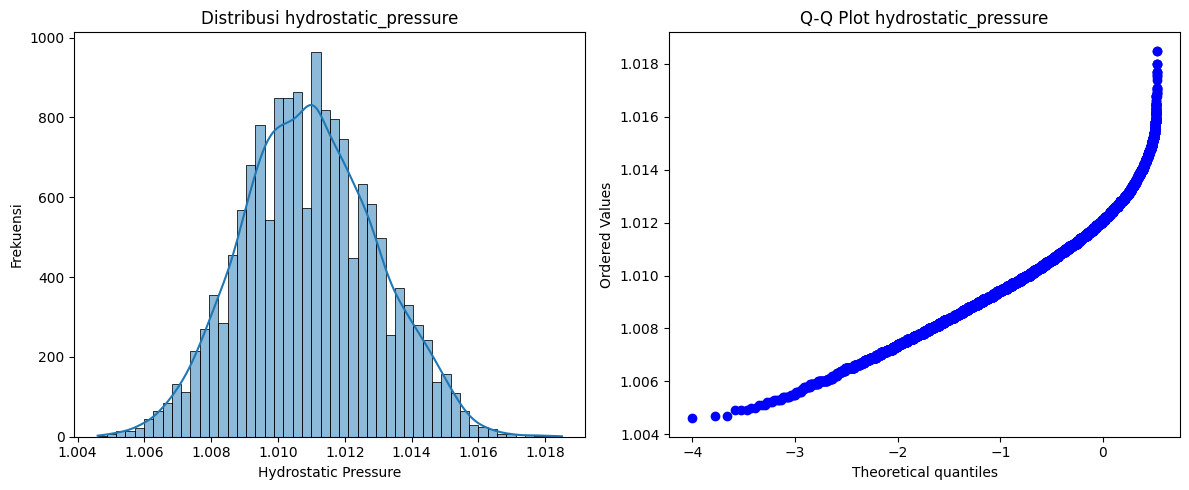


Statistik Deskriptif untuk hydrostatic_pressure:
count    15321.000000
mean         1.010953
std          0.002010
min          1.004600
25%          1.009600
50%          1.010900
75%          1.012300
max          1.018500
Name: hydrostatic_pressure, dtype: float64
Skewness: 0.101
Kurtosis: -0.207


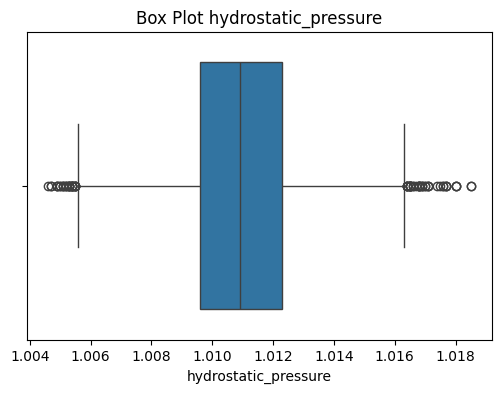

In [114]:
# --- 1. Analisis Variabel Target (hydrostatic_pressure) ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df[TARGET], kde=True, bins=50)
plt.title(f'Distribusi {TARGET}')
plt.xlabel('Hydrostatic Pressure')
plt.ylabel('Frekuensi')

plt.subplot(1, 2, 2)
stats.probplot(df[TARGET], dist="norm", plot=plt)
plt.title(f'Q-Q Plot {TARGET}')

plt.tight_layout()
plt.show()

print(f"\nStatistik Deskriptif untuk {TARGET}:")
print(df[TARGET].describe())
skewness = df[TARGET].skew()
kurt = df[TARGET].kurt()
print(f"Skewness: {skewness:.3f}")
print(f"Kurtosis: {kurt:.3f}")

# --- Analisis Outlier Target ---
plt.figure(figsize=(6, 4))
sns.boxplot(x=df[TARGET])
plt.title(f'Box Plot {TARGET}')
plt.show()

# Kesimpulan Awal Target:
# Periksa output plot dan statistik. Apakah distribusinya mendekati normal? Apakah ada skewness?
# Apakah ada outlier signifikan yang terlihat dari box plot?
# (Hydrostatic pressure biasanya berkorelasi kuat dengan kedalaman, jadi distribusinya mungkin tidak normal sempurna)
# Target tampaknya cukup baik, mungkin tidak perlu transformasi drastis untuk model tree-based.

In [115]:
# --- 3. Analisis Korelasi ---
# Pilih hanya kolom numerik untuk matriks korelasi
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

# Hitung matriks korelasi
correlation_matrix = df[numerical_cols].corr()

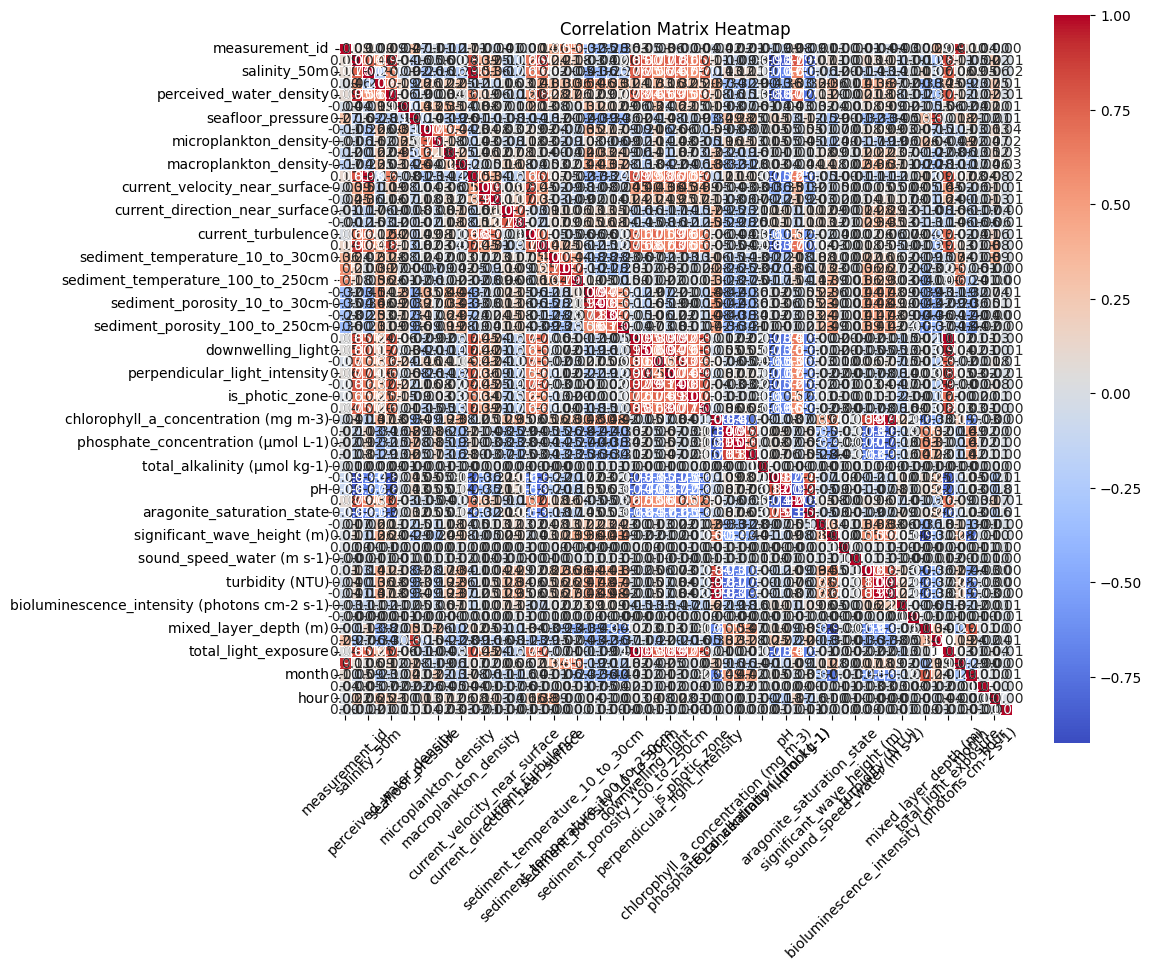

In [116]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Ambil hanya kolom numerik
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

# 2. Hitung matriks korelasi
correlation_matrix = df[numerical_cols].corr()

# 3. Visualisasi heatmap korelasi
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 4. Ubah matriks korelasi menjadi bentuk long format
correlation_long = (
    correlation_matrix.stack()
    .reset_index()
    .rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: "Correlation"})
)

# 5. Simpan ke CSV
correlation_long.to_csv("correlation_matrix_long.csv", index=False)


Feature pairs with correlation > 0.7:


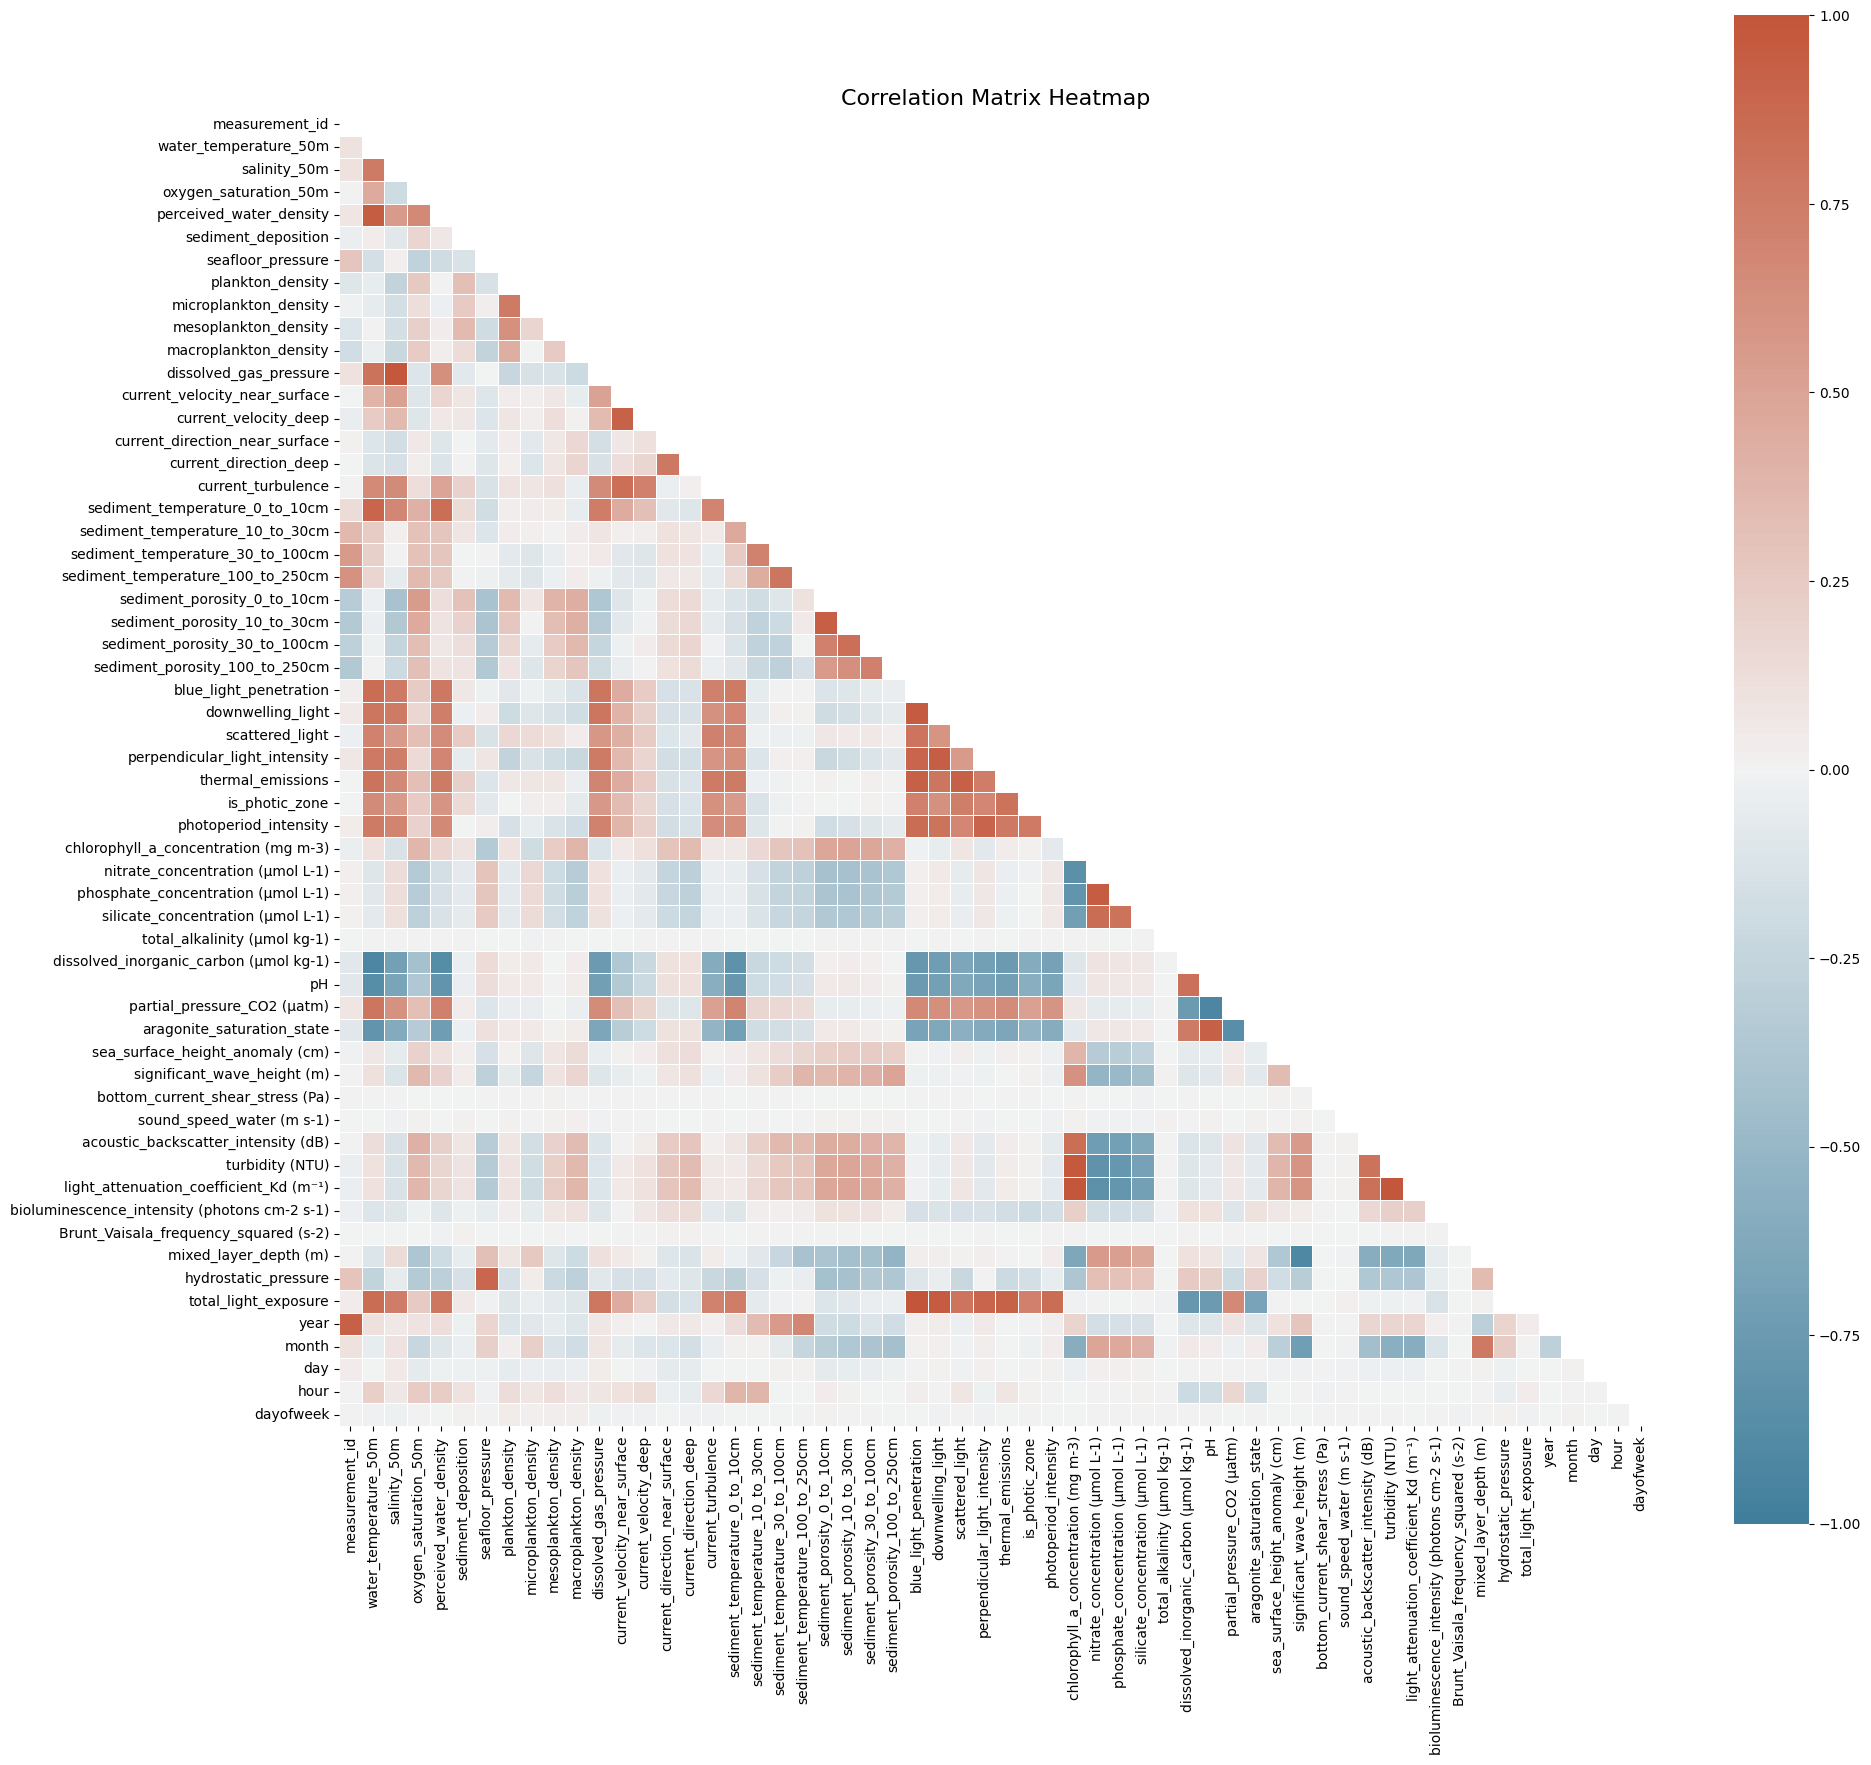

In [117]:
# Select numerical columns for correlation analysis
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

# Calculate correlation matrix
correlation_matrix = df[numerical_cols].corr()

# Define high correlation threshold
high_corr_threshold = 0.7

# Create mask for upper triangle to avoid redundancy
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Create a figure with appropriate size
plt.figure(figsize=(20, 18))

# Define a diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Create heatmap
sns.heatmap(
    correlation_matrix, 
    mask=mask,
    annot=False,  # No annotations for clarity with many variables
    cmap=cmap,
    center=0,
    linewidths=0.5,
    square=True,
    vmin=-1, 
    vmax=1
)

plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Identify highly correlated feature pairs
high_corr_features = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > high_corr_threshold:
            high_corr_features.append((
                correlation_matrix.columns[i], 
                correlation_matrix.columns[j], 
                correlation_matrix.iloc[i, j]
            ))

# Print highly correlated features
print(f"\nFeature pairs with correlation > {high_corr_threshold}:")
high_corr_df = pd.DataFrame(high_corr_features, columns=['Feature 1', 'Feature 2', 'Correlation'])
high_corr_df = high_corr_df.sort_values('Correlation', ascending=False)
high_corr_df.to_csv('data/regression-rumble-ndc-2025/high_corr_features.csv', index=False)

In [118]:
# Korelasi fitur dengan target
target_correlation = correlation_matrix[TARGET].sort_values(ascending=False)
print(f"\nKorelasi Fitur dengan {TARGET} (Top 15 Positif & Negatif):")
print(target_correlation.head(15))
print("\n")
print(target_correlation.tail(15))


Korelasi Fitur dengan hydrostatic_pressure (Top 15 Positif & Negatif):
hydrostatic_pressure                      1.000000
seafloor_pressure                         0.885065
mixed_layer_depth (m)                     0.344374
nitrate_concentration (µmol L-1)          0.323610
phosphate_concentration (µmol L-1)        0.308278
measurement_id                            0.291425
silicate_concentration (µmol L-1)         0.281832
dissolved_inorganic_carbon (µmol kg-1)    0.250165
month                                     0.237737
pH                                        0.218666
aragonite_saturation_state                0.202657
year                                      0.192452
microplankton_density                     0.043264
dayofweek                                 0.013210
perpendicular_light_intensity             0.001256
Name: hydrostatic_pressure, dtype: float64


water_temperature_50m                    -0.270159
macroplankton_density                    -0.281946
sediment_tempera

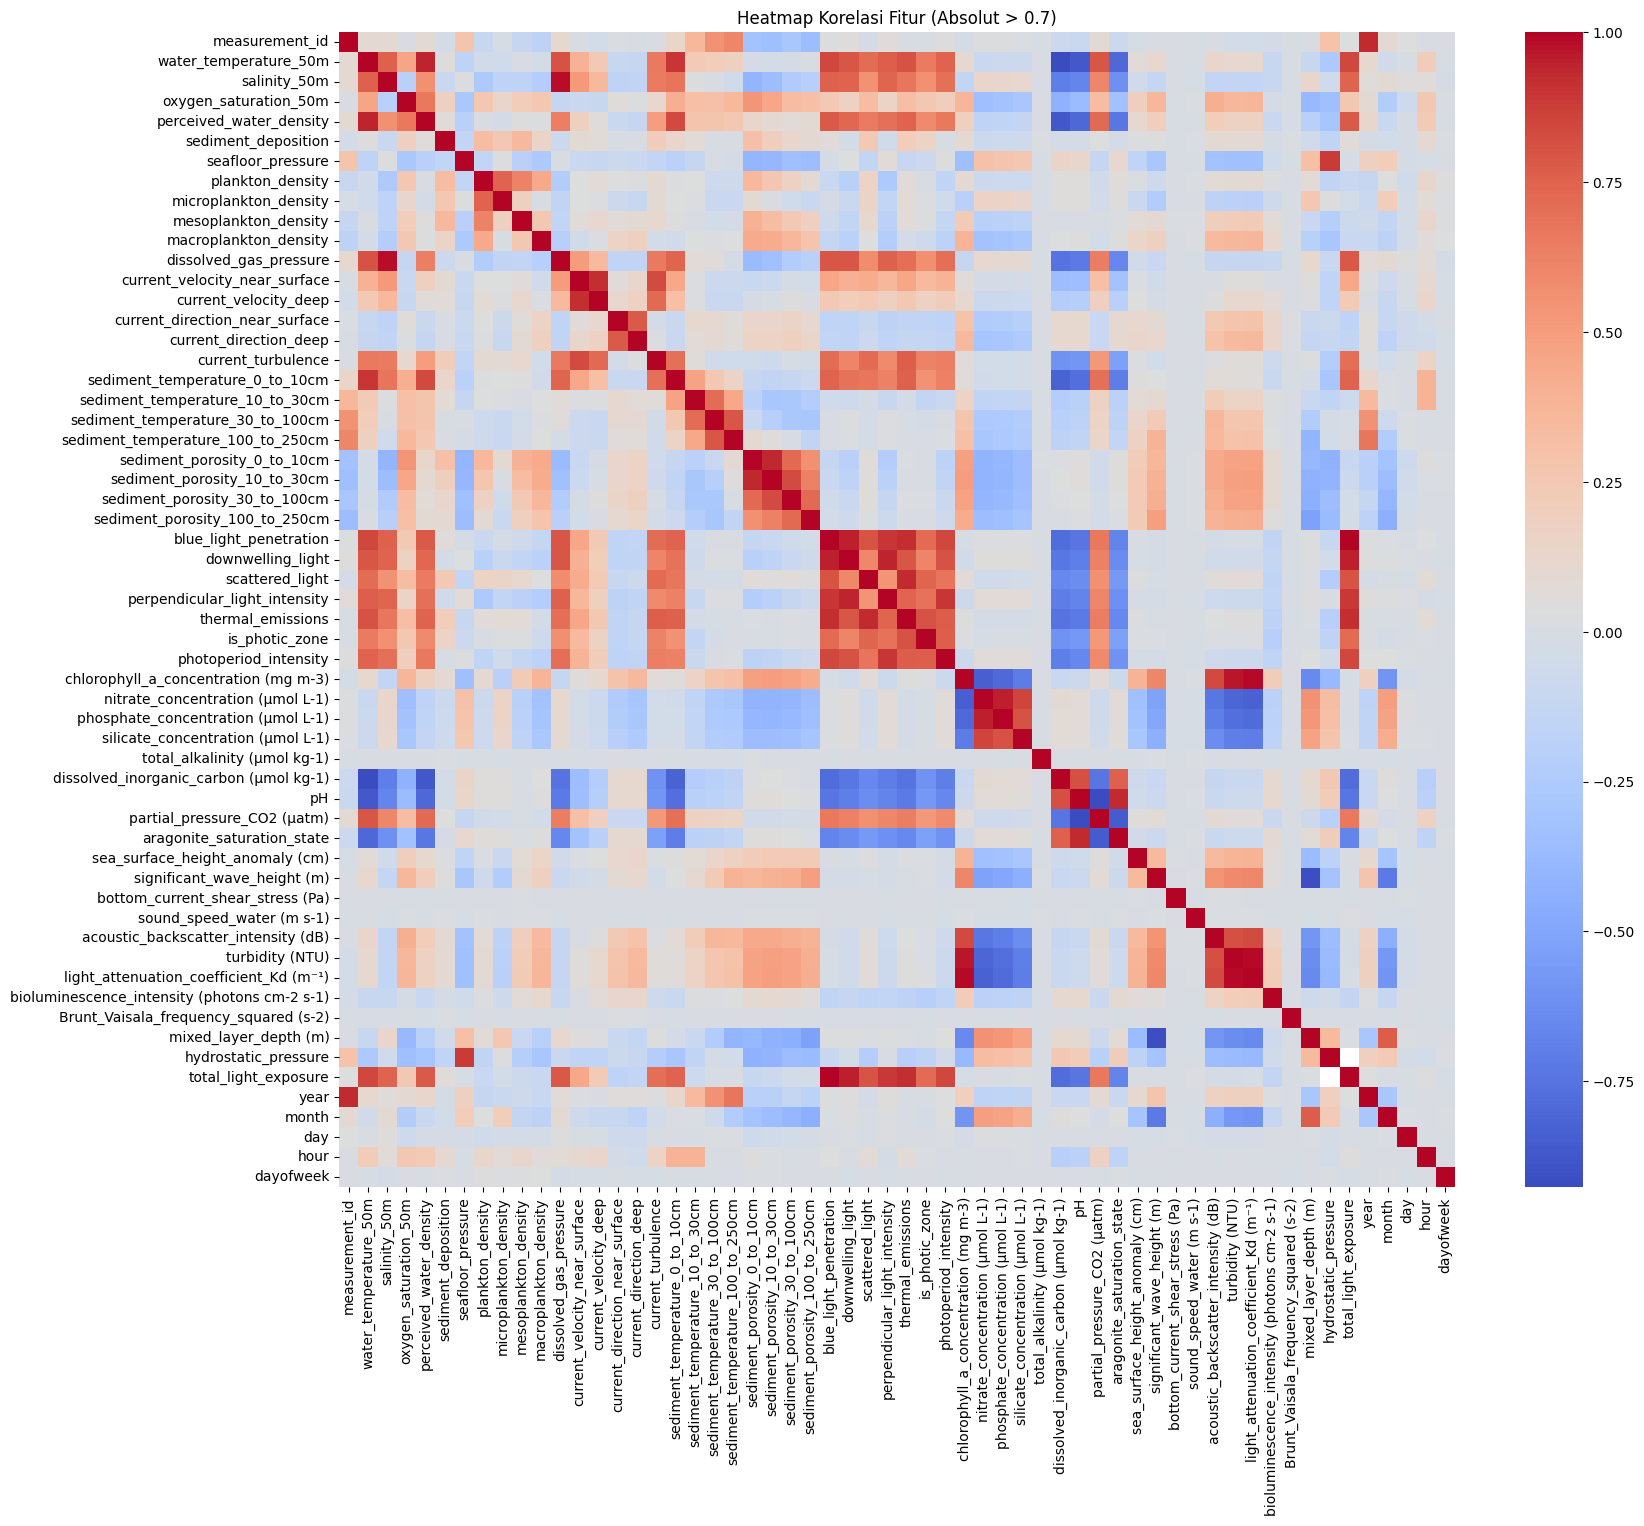

In [119]:
# Visualisasi Korelasi Fitur-Fitur (Heatmap) - Fokus pada korelasi tinggi
plt.figure(figsize=(18, 15))

# Pilih fitur dengan korelasi absolut tinggi (misal > 0.7) untuk visualisasi yang lebih bersih
high_corr_features = correlation_matrix[correlation_matrix.abs() > 0]
sns.heatmap(high_corr_features, annot=False, cmap='coolwarm', fmt=".2f") # Annot=True bisa sangat padat
plt.title('Heatmap Korelasi Fitur (Absolut > 0.7)')
plt.show()

### Implement iterative imputation

#### All Column

In [96]:
# Select relevant features for imputation (excluding ID and timestamp)
features_for_imputation = df.columns.drop(['measurement_id', 'depth_reading_time', 'hydrostatic_pressure', 'total_light_exposure']).tolist()
X = df[features_for_imputation]

In [97]:
# 1. Fungsi untuk mendeteksi outlier pada data
def detect_and_handle_outliers(X, threshold=3):
    """
    Mendeteksi outlier menggunakan metode Z-score dan menggantinya dengan nilai batas
    threshold: jumlah standar deviasi untuk mengidentifikasi outlier
    """
    X_clean = X.copy()
    for col in X.columns:
        if X[col].dtype.kind in 'bifc':  # Hanya kolom numerik
            z_scores = np.abs((X[col] - X[col].mean()) / X[col].std())
            outliers = z_scores > threshold
            
            # Ganti outlier dengan batas atas atau bawah (capping)
            upper_bound = X[col].mean() + threshold * X[col].std()
            lower_bound = X[col].mean() - threshold * X[col].std()
            
            X_clean.loc[outliers & (X[col] > upper_bound), col] = upper_bound
            X_clean.loc[outliers & (X[col] < lower_bound), col] = lower_bound
            
            print(f"Kolom {col}: {outliers.sum()} outlier ditemukan dan ditangani")
    
    return X_clean

# 2. Optimasi hyperparameter untuk XGBoost
def optimize_xgboost_params(X, cv=5):
    """
    Melakukan pencarian acak untuk menemukan hyperparameter terbaik
    cv: jumlah fold untuk cross-validation (default 5)
    """
    # Pisahkan sebagian kecil dataset untuk optimasi
    sample_size = min(5000, X.shape[0])  # Batasi ukuran sampel untuk kecepatan
    sample_indices = np.random.choice(X.shape[0], size=sample_size, replace=False)
    X_sample = X.iloc[sample_indices]
    
    # Buat matriks dummy untuk target (untuk regresi kita hanya butuh nilai acak)
    y_dummy = np.random.randn(sample_size)
    
    # Definisikan ruang parameter
    param_dist = {
        'n_estimators': randint(100, 300),
        'learning_rate': uniform(0.01, 0.2),
        'max_depth': randint(3, 10),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4),
        'min_child_weight': randint(1, 10),
        'gamma': uniform(0, 0.5),
        'reg_alpha': uniform(0, 1),
        'reg_lambda': uniform(0, 1)
    }
    
    # Buat model dasar
    xgb_base = xgb.XGBRegressor(
        objective='reg:squarederror',
        tree_method='hist',
        random_state=SEED,
        n_jobs=-1
    )
    
    # Buat cross-validator
    # Untuk dataset besar, stratifikasi bisa menjadi masalah
    # jadi kita gunakan KFold sederhana dengan shuffling
    kf = KFold(n_splits=cv, shuffle=True, random_state=SEED)
    
    # Buat pencari parameter
    random_search = RandomizedSearchCV(
        estimator=xgb_base,
        param_distributions=param_dist,
        n_iter=30,
        scoring='neg_mean_squared_error',
        cv=kf,
        verbose=1,
        random_state=SEED,
        n_jobs=-1
    )
    
    # Fill NaN values temporarily for optimization
    X_sample_filled = X_sample.fillna(X_sample.median())
    
    # Fit model
    random_search.fit(X_sample_filled, y_dummy)
    
    print("Parameter terbaik:", random_search.best_params_)
    return random_search.best_params_

# 3. Proses untuk persiapan data 
def prepare_data(X):
    """
    Mempersiapkan data sebelum imputasi
    """
    # Hitung korelasi antar fitur
    correlation_matrix = X.corr(method='pearson', min_periods=100)
    
    # Identifikasi fitur dengan korelasi tinggi (multi-collinearity)
    threshold = 0.85
    high_corr_pairs = []
    
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                colname_i = correlation_matrix.columns[i]
                colname_j = correlation_matrix.columns[j]
                high_corr_pairs.append((colname_i, colname_j, correlation_matrix.iloc[i, j]))
    
    if high_corr_pairs:
        print(f"Ditemukan {len(high_corr_pairs)} pasangan fitur dengan korelasi tinggi (>{threshold}):")
        for col1, col2, corr in high_corr_pairs:
            print(f"  {col1} dan {col2}: {corr:.4f}")
    
    # Identifikasi fitur dengan terlalu banyak nilai hilang
    missing_ratio = X.isnull().mean()
    too_many_missing = missing_ratio[missing_ratio > 0.5].index.tolist()
    
    if too_many_missing:
        print(f"Fitur dengan >80% nilai hilang: {too_many_missing}")
        print("Pertimbangkan untuk menghapus fitur-fitur ini.")
    
    return X

# 4. Fungsi utama untuk melakukan imputasi XGBoost yang dioptimasi
def optimized_xgboost_imputation(X, max_iter=15, optimize=True):
    """
    Melakukan imputasi data dengan XGBoost yang telah dioptimasi
    X: DataFrame dengan nilai yang hilang
    max_iter: jumlah iterasi maksimum untuk IterativeImputer
    optimize: apakah akan melakukan optimasi hyperparameter
    """
    print(f"\nMemulai proses imputasi untuk data dengan bentuk {X.shape}...")
    
    # Persiapan data
    X = prepare_data(X)
    
    # Deteksi dan tangani outlier
    X_no_outliers = detect_and_handle_outliers(X)
    
    # Optimasi hyperparameter jika diminta
    if optimize:
        print("\nMemulai optimasi hyperparameter XGBoost...")
        best_params = optimize_xgboost_params(X_no_outliers)
        xgb_estimator = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=best_params['n_estimators'],
            learning_rate=best_params['learning_rate'],
            max_depth=best_params['max_depth'],
            subsample=best_params['subsample'],
            colsample_bytree=best_params['colsample_bytree'],
            min_child_weight=best_params['min_child_weight'],
            gamma=best_params['gamma'],
            reg_alpha=best_params['reg_alpha'],
            reg_lambda=best_params['reg_lambda'],
            random_state=SEED,
            n_jobs=-1,
            tree_method='hist',
            importance_type='gain'  # Untuk feature importance
        )
    else:
        # Gunakan parameter yang sudah dioptimasi sebelumnya untuk dataset sejenis
        xgb_estimator = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=200,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            min_child_weight=3,
            gamma=0.1,
            reg_alpha=0.1,
            reg_lambda=0.2,
            random_state=SEED,
            n_jobs=-1,
            tree_method='hist',
            importance_type='gain'
        )
    
    # Buat IterativeImputer dengan estimator XGBoost
    iterative_imputer_xgb = IterativeImputer(
        estimator=xgb_estimator,
        max_iter=max_iter,
        initial_strategy='median',
        imputation_order='ascending', 
        random_state=SEED,
        sample_posterior=False,
        verbose=2,
        skip_complete=True,
        add_indicator=True
    )
    
    # Simpan urutan kolom asli
    original_columns = X.columns.tolist()
    
    print("\nMemulai imputasi iteratif dengan XGBoost yang dioptimasi...")
    
    # Lakukan imputasi
    X_imputed_array = iterative_imputer_xgb.fit_transform(X_no_outliers)
    
    # Konversi hasil kembali ke DataFrame dengan penanganan indikator yang lebih aman
    n_features_original = X.shape[1]
    
    # Cara yang lebih aman untuk menangani kolom indikator
    if hasattr(iterative_imputer_xgb, 'indicator_') and iterative_imputer_xgb.add_indicator:
        # Hitung berapa banyak kolom indikator yang ditambahkan
        n_indicators = sum(iterative_imputer_xgb.indicator_.features_)
        # Buat daftar nama kolom baru
        missing_indicators = [f"missing_indicator_{i}" for i in range(n_indicators)]
        all_columns = original_columns + missing_indicators
    else:
        all_columns = original_columns
    
    # Pastikan jumlah kolom sesuai dengan output
    final_columns = all_columns[:X_imputed_array.shape[1]]
    
    X_imputed_xgb = pd.DataFrame(
        X_imputed_array,
        columns=final_columns,
        index=X.index
    )
    
    # Verifikasi hasil imputasi
    print("\nImputasi data dengan XGBoost selesai.")
    print(f"Bentuk data setelah imputasi: {X_imputed_xgb.shape}")
    print(f"Jumlah nilai hilang setelah imputasi: {X_imputed_xgb.isnull().sum().sum()}")
    
    # Analisis feature importance dari estimator terakhir secara aman
    if hasattr(iterative_imputer_xgb, 'estimators_') and iterative_imputer_xgb.estimators_:
        try:
            # Ambil estimator dari iterasi terakhir untuk fitur pertama
            last_estimator = iterative_imputer_xgb.estimators_[-1][0]
            
            if hasattr(last_estimator, 'feature_importances_'):
                # Dapatkan feature importance
                importances = last_estimator.feature_importances_
                # Pastikan panjang importances sesuai dengan jumlah kolom
                if len(importances) <= len(original_columns):
                    indices = np.argsort(importances)[::-1]
                    
                    # Plot top N feature importance
                    N = min(20, len(importances))
                    # Pastikan indeks berada dalam range yang valid
                    valid_indices = [i for i in indices[:N] if i < len(original_columns)]
                    valid_importances = importances[valid_indices]
                    feature_names = [original_columns[i] for i in valid_indices]
                    
                    plt.figure(figsize=(12, 8))
                    plt.title('Top Feature Importances dalam Proses Imputasi')
                    plt.barh(range(len(valid_indices)), valid_importances, align='center')
                    plt.yticks(range(len(valid_indices)), feature_names)
                    plt.xlabel('Relative Importance')
                    plt.tight_layout()
                    plt.show()
        except Exception as e:
            print(f"Gagal menganalisis feature importance: {e}")

    return X_imputed_xgb

In [98]:
X_imputed = optimized_xgboost_imputation(X, max_iter=10, optimize=True)


Memulai proses imputasi untuk data dengan bentuk (21888, 55)...
Ditemukan 21 pasangan fitur dengan korelasi tinggi (>0.85):
  perceived_water_density dan water_temperature_50m: 0.9470
  dissolved_gas_pressure dan salinity_50m: 0.9836
  current_velocity_deep dan current_velocity_near_surface: 0.9147
  sediment_temperature_0_to_10cm dan water_temperature_50m: 0.9026
  sediment_porosity_10_to_30cm dan sediment_porosity_0_to_10cm: 0.9341
  downwelling_light dan blue_light_penetration: 0.9579
  perpendicular_light_intensity dan blue_light_penetration: 0.9006
  perpendicular_light_intensity dan downwelling_light: 0.9457
  thermal_emissions dan blue_light_penetration: 0.9244
  thermal_emissions dan scattered_light: 0.9277
  photoperiod_intensity dan blue_light_penetration: 0.8508
  photoperiod_intensity dan perpendicular_light_intensity: 0.9031
  phosphate_concentration (µmol L-1) dan nitrate_concentration (µmol L-1): 0.9467
  dissolved_inorganic_carbon (µmol kg-1) dan water_temperature_50m:

In [99]:
# Tampilkan jumlah missing values sebelum dan sesudah
print("\nJumlah missing values sebelum imputasi:")
print(X.isna().sum().sum())

print("\nJumlah missing values setelah imputasi:")
print(X_imputed.isna().sum().sum())


Jumlah missing values sebelum imputasi:
228519

Jumlah missing values setelah imputasi:
0


In [105]:
def process_imputation_results(df, X_imputed):
    """
    Proses hasil imputasi dan kembalikan dataframe siap pakai
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame asli
    X_imputed : DataFrame
        DataFrame hasil imputasi
        
    Returns:
    --------
    DataFrame
        DataFrame yang sudah terisi nilai kosongnya
    """
    # 1. Identifikasi kolom indikator dan kolom asli
    indicator_columns = [col for col in X_imputed.columns if col.startswith('missing_indicator_')]
    original_columns = [col for col in X_imputed.columns if not col.startswith('missing_indicator_')]
    
    print(f"\nKolom asli: {len(original_columns)}")
    print(f"Kolom indikator: {len(indicator_columns)}")
    
    # 2. Ekstrak hanya kolom asli
    X_imputed_original = X_imputed[original_columns]
    
    # 3. Terapkan ke dataframe asli
    df_imputed = df.copy()
    
    print("\nMengisi nilai null di dataframe...")
    print(f"Jumlah nilai kosong sebelum: {df_imputed.isna().sum().sum()}")
    
    # Isi hanya kolom yang ada di df asli
    for column in original_columns:
        if column in df_imputed.columns:
            missing_mask = df_imputed[column].isna()
            if missing_mask.any():
                df_imputed.loc[missing_mask, column] = X_imputed_original.loc[missing_mask, column]
                print(f"Mengisi {missing_mask.sum()} nilai kosong di kolom '{column}'")
    
    # 4. Konversi kolom is_photic_zone menjadi biner (0 dan 1)
    if 'is_photic_zone' in df_imputed.columns:
        print("\nMengkonversi kolom is_photic_zone menjadi nilai biner...")
        df_imputed['is_photic_zone'] = (df_imputed['is_photic_zone'] > 0.5).astype(int)
        print(f"Distribusi nilai is_photic_zone setelah konversi: {df_imputed['is_photic_zone'].value_counts().to_dict()}")
    
    print(f"Jumlah nilai kosong setelah: {df_imputed.isna().sum().sum()}")
    
    return df_imputed

In [106]:
df_imputed = process_imputation_results(df, X_imputed)
df_imputed.to_csv('data/clean/data_imputed.csv', index=False)


Kolom asli: 55
Kolom indikator: 50

Mengisi nilai null di dataframe...
Jumlah nilai kosong sebelum: 251283
Mengisi 11513 nilai kosong di kolom 'water_temperature_50m'
Mengisi 4778 nilai kosong di kolom 'salinity_50m'
Mengisi 4237 nilai kosong di kolom 'oxygen_saturation_50m'
Mengisi 1407 nilai kosong di kolom 'perceived_water_density'
Mengisi 7131 nilai kosong di kolom 'sediment_deposition'
Mengisi 4433 nilai kosong di kolom 'seafloor_pressure'
Mengisi 7336 nilai kosong di kolom 'plankton_density'
Mengisi 6152 nilai kosong di kolom 'microplankton_density'
Mengisi 5530 nilai kosong di kolom 'mesoplankton_density'
Mengisi 3837 nilai kosong di kolom 'macroplankton_density'
Mengisi 3736 nilai kosong di kolom 'dissolved_gas_pressure'
Mengisi 7827 nilai kosong di kolom 'current_velocity_near_surface'
Mengisi 4118 nilai kosong di kolom 'current_velocity_deep'
Mengisi 4619 nilai kosong di kolom 'current_direction_near_surface'
Mengisi 4768 nilai kosong di kolom 'current_direction_deep'
Mengis

In [107]:
# Verifikasi hasil imputasi
print("\n===== VERIFIKASI HASIL IMPUTASI =====")
print("Jumlah nilai yang hilang sebelum imputasi:", df.isna().sum().sum())
print("Jumlah nilai yang hilang setelah imputasi:", df_imputed.isna().sum().sum())


===== VERIFIKASI HASIL IMPUTASI =====
Jumlah nilai yang hilang sebelum imputasi: 251283
Jumlah nilai yang hilang setelah imputasi: 22764


In [108]:
# 5. Periksa distribusi statistik sebelum dan sesudah imputasi
print("\n===== STATISTIK SEBELUM DAN SESUDAH IMPUTASI =====")
# Pilih beberapa kolom dengan missing values terbanyak untuk ditampilkan
missing_counts = df.isna().sum()
top_missing_cols = missing_counts[missing_counts > 0].sort_values(ascending=False).head(5).index.tolist()

if top_missing_cols:
    for col in top_missing_cols:
        print(f"\nStatistik untuk kolom '{col}':")
        print("SEBELUM:")
        print(f"- Mean: {df[col].mean():.4f}")
        print(f"- Std: {df[col].std():.4f}")
        print(f"- Min: {df[col].min():.4f}")
        print(f"- Max: {df[col].max():.4f}")
        
        print("SESUDAH:")
        print(f"- Mean: {df_imputed[col].mean():.4f}")
        print(f"- Std: {df_imputed[col].std():.4f}")
        print(f"- Min: {df_imputed[col].min():.4f}")
        print(f"- Max: {df_imputed[col].max():.4f}")


===== STATISTIK SEBELUM DAN SESUDAH IMPUTASI =====

Statistik untuk kolom 'total_light_exposure':
SEBELUM:
- Mean: 203.1866
- Std: 279.0818
- Min: 0.0000
- Max: 1039.0000
SESUDAH:
- Mean: 203.1866
- Std: 279.0818
- Min: 0.0000
- Max: 1039.0000

Statistik untuk kolom 'aragonite_saturation_state':
SEBELUM:
- Mean: 2.6976
- Std: 0.2402
- Min: 1.7393
- Max: 3.4472
SESUDAH:
- Mean: 2.7022
- Std: 0.1791
- Min: 1.7393
- Max: 3.4472

Statistik untuk kolom 'pH':
SEBELUM:
- Mean: 8.0987
- Std: 0.1095
- Min: 7.7000
- Max: 8.3000
SESUDAH:
- Mean: 8.1002
- Std: 0.0838
- Min: 7.7000
- Max: 8.3000

Statistik untuk kolom 'water_temperature_50m':
SEBELUM:
- Mean: 297.9953
- Std: 2.4616
- Min: 290.3500
- Max: 307.6500
SESUDAH:
- Mean: 297.9863
- Std: 2.2344
- Min: 290.3500
- Max: 307.6500

Statistik untuk kolom 'dissolved_inorganic_carbon (µmol kg-1)':
SEBELUM:
- Mean: 2049.8755
- Std: 33.6046
- Min: 1915.6340
- Max: 2163.9688
SESUDAH:
- Mean: 2050.2288
- Std: 28.5106
- Min: 1915.6340
- Max: 2163.9688



Visualisasi distribusi data sebelum dan sesudah imputasi telah dibuat.


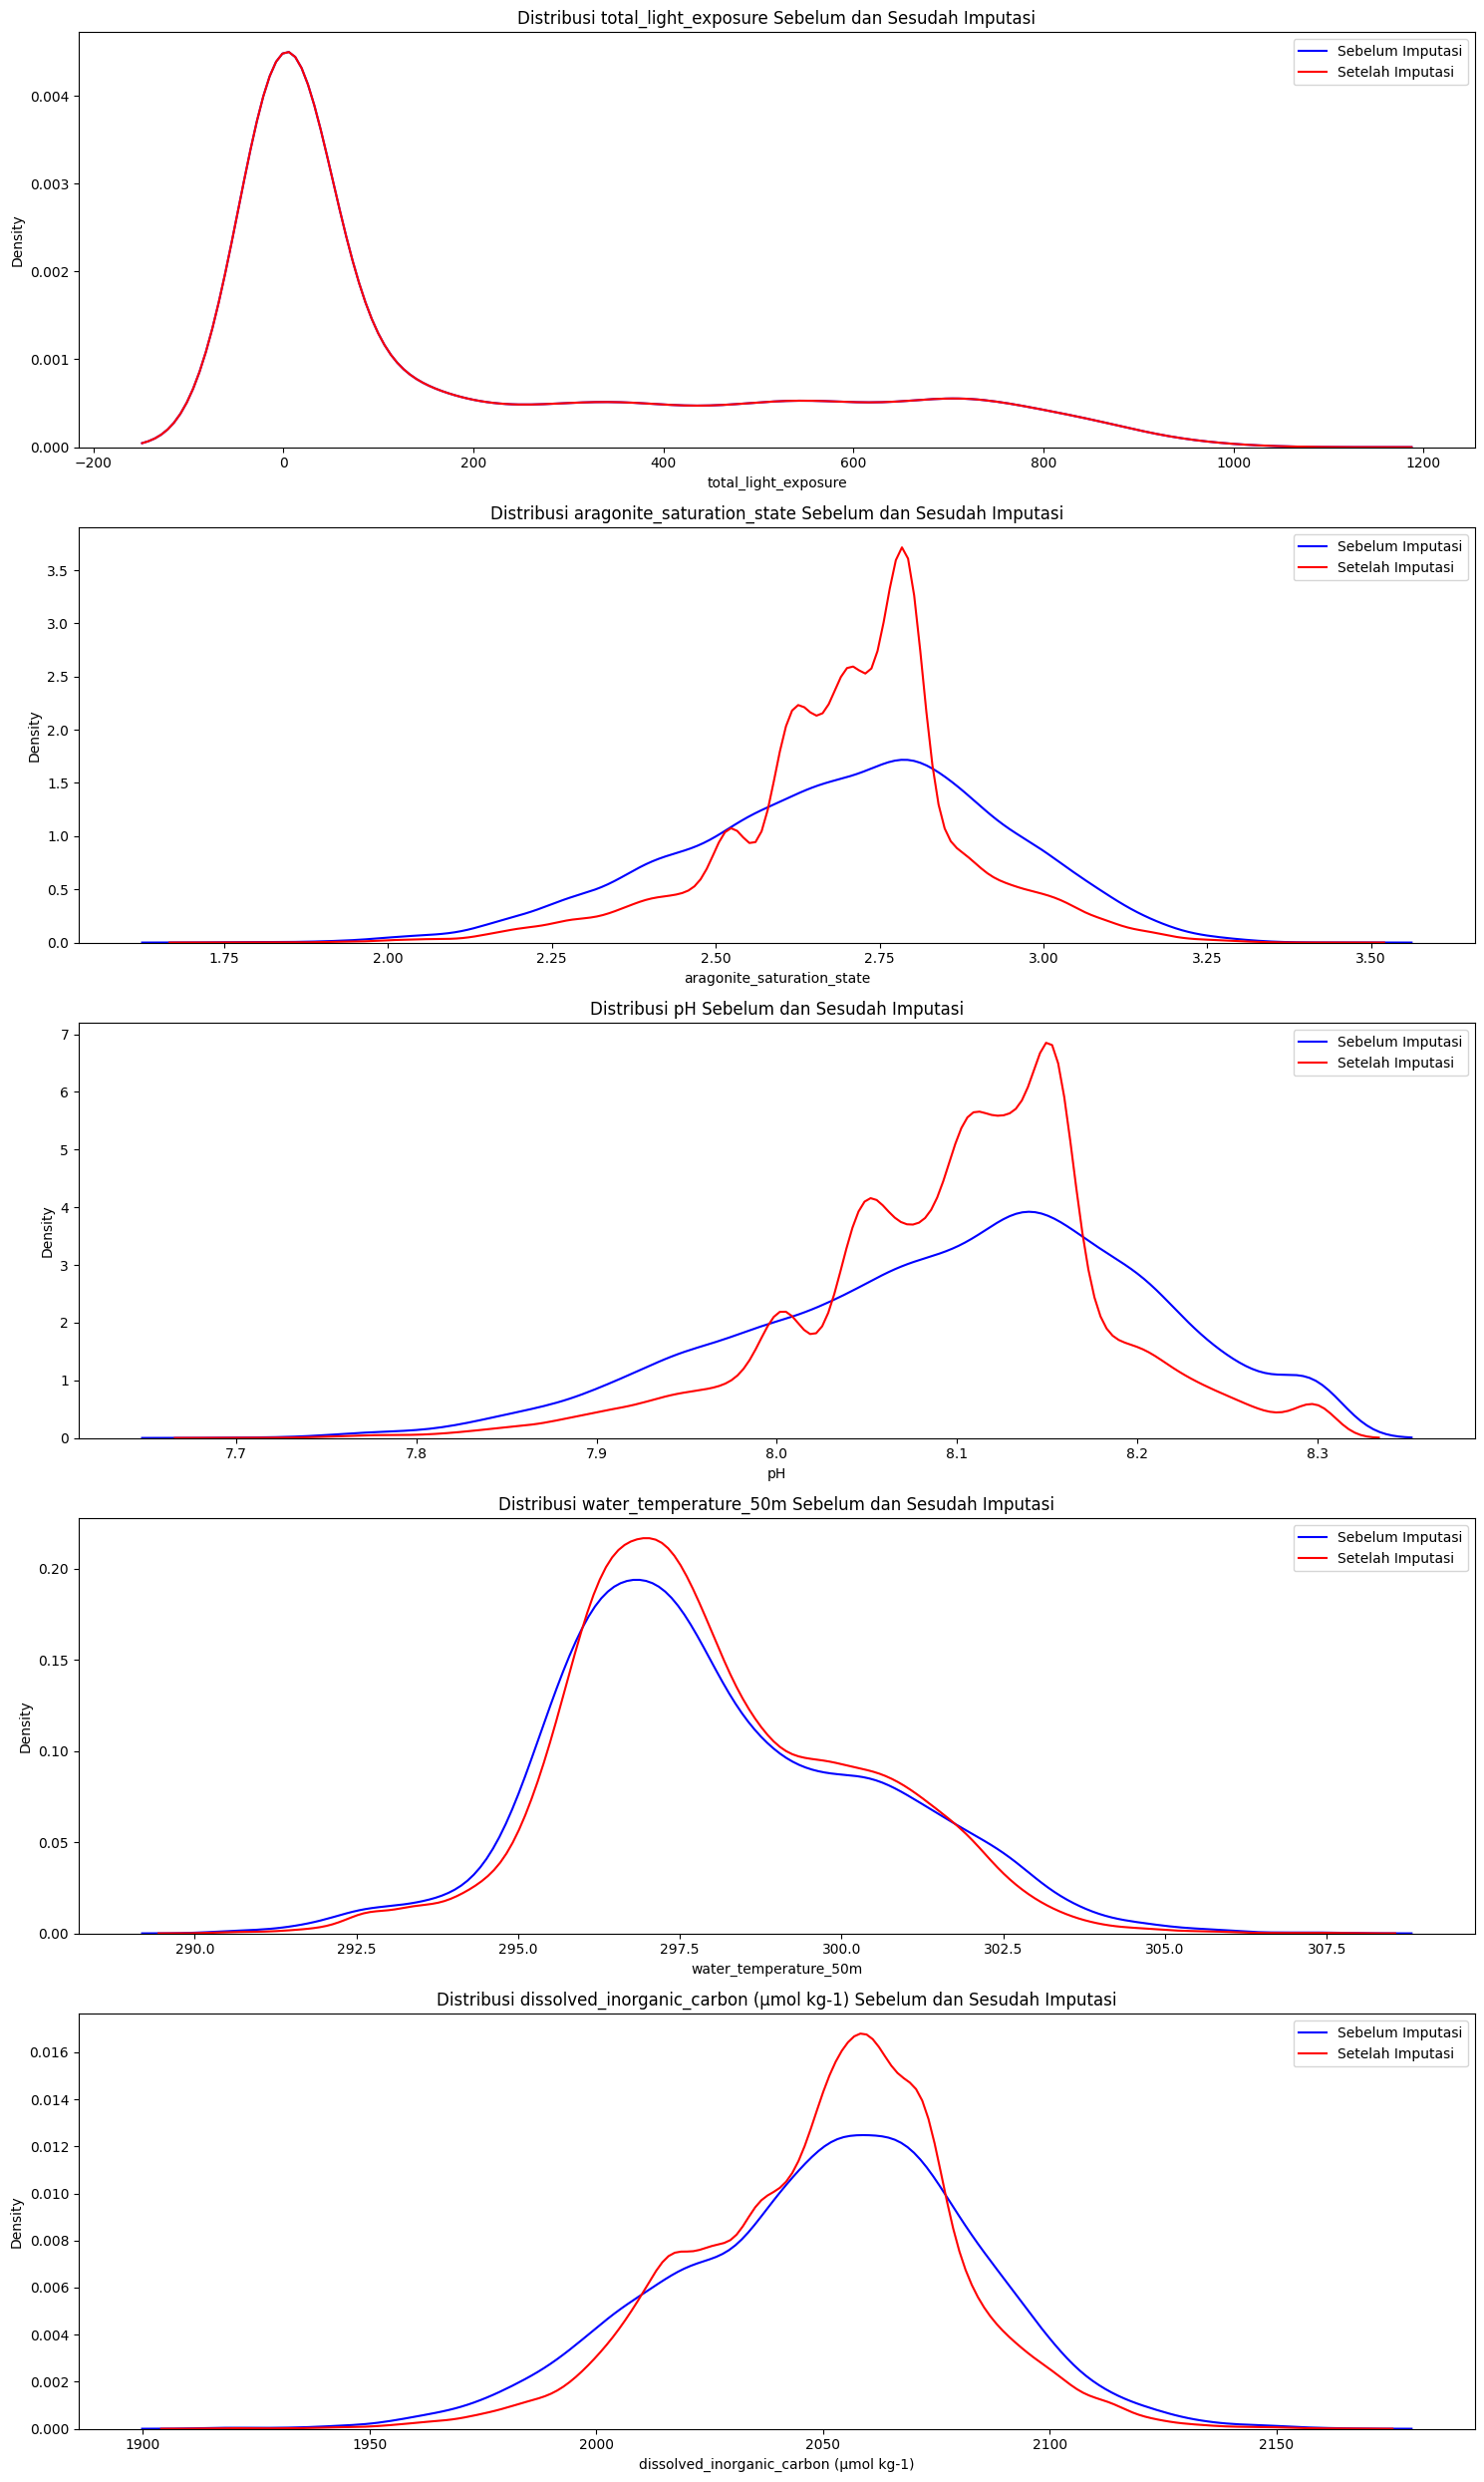

In [109]:
# 7. Visualisasi Distribusi Data Sebelum dan Sesudah Imputasi
plt.figure(figsize=(15, 5*len(top_missing_cols)))

for i, col in enumerate(top_missing_cols):
    plt.subplot(len(top_missing_cols), 1, i+1)
    
    # Tampilkan distribusi sebelum dan sesudah imputasi
    sns.kdeplot(df[col].dropna(), label='Sebelum Imputasi', color='blue')
    sns.kdeplot(df_imputed[col], label='Setelah Imputasi', color='red')
    
    plt.title(f'Distribusi {col} Sebelum dan Sesudah Imputasi')
    plt.legend()

plt.tight_layout()
print("\nVisualisasi distribusi data sebelum dan sesudah imputasi telah dibuat.")

In [112]:
# Load the original train and test files to get the IDs
df_train_original = pd.read_csv('data/regression-rumble-ndc-2025/train.csv')
df_test_original = pd.read_csv('data/regression-rumble-ndc-2025/test.csv')

# Get the measurement IDs from the original files
train_ids = df_train_original['measurement_id'].tolist()
test_ids = df_test_original['measurement_id'].tolist()

# Split the imputed data based on the original IDs
df_train_imputed = df_imputed[df_imputed['measurement_id'].isin(train_ids)].copy()
df_test_imputed = df_imputed[df_imputed['measurement_id'].isin(test_ids)].copy()

# Verify the split worked correctly
print(f"Original train dataset shape: {df_train_original.shape}")
print(f"Imputed train dataset shape: {df_train_imputed.shape}")
print(f"Original test dataset shape: {df_test_original.shape}")
print(f"Imputed test dataset shape: {df_test_imputed.shape}")

# Verify all IDs were matched correctly
train_ids_matched = set(df_train_imputed['measurement_id'].tolist()) == set(train_ids)
test_ids_matched = set(df_test_imputed['measurement_id'].tolist()) == set(test_ids)
print(f"All train IDs matched correctly: {train_ids_matched}")
print(f"All test IDs matched correctly: {test_ids_matched}")

# Save the split imputed data
df_train_imputed.to_csv('data/clean/train_imputed.csv', index=False)
df_test_imputed.to_csv('data/clean/test_imputed.csv', index=False)

Original train dataset shape: (15321, 53)
Imputed train dataset shape: (15321, 59)
Original test dataset shape: (6567, 53)
Imputed test dataset shape: (6567, 59)
All train IDs matched correctly: True
All test IDs matched correctly: True


## Feature Engineering

### Total Light Exposure

In [47]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

In [49]:
# Load the data
# Gantilah 'data/clean/data.csv' dengan path file Anda yang sebenarnya jika berbeda
df = pd.read_csv('data/clean/test_imputed.csv')
TARGET = 'total_light_exposure'

In [50]:
# 1. Pemisahan Data
df_train_val = df[df[TARGET].notna()].copy()
df_test = df[df[TARGET].isna()].copy()

print(f"Jumlah data latih dan validasi awal: {len(df_train_val)}")
print(f"Jumlah data tes awal: {len(df_test)}")

Jumlah data latih dan validasi awal: 5691
Jumlah data tes awal: 876


In [51]:
# Identifikasi Fitur Awal
initial_features = [col for col in df.columns if col not in ['measurement_id', 'depth_reading_time', 'hydrostatic_pressure', TARGET]]
X_train_val = df_train_val[initial_features].copy()
y_train_val = df_train_val[TARGET].copy()
X_test = df_test[initial_features].copy() # Simpan X_test awal untuk transformasi nanti

In [52]:
# Pastikan tidak ada NaN di fitur pada data latih sebelum VIF dan korelasi
# Jika ada, perlu diimputasi. Untuk VIF, kita bisa drop baris dengan NaN sementara atau imputasi.
# Untuk kesederhanaan, kita akan drop baris dengan NaN di fitur pada X_train_val
# Namun, praktik terbaik adalah imputasi.
X_train_val_cleaned_for_vif = X_train_val.dropna()
y_train_val_for_vif = y_train_val[X_train_val_cleaned_for_vif.index] # Sesuaikan y juga

In [53]:
# 2. Seleksi Fitur Berdasarkan VIF
print("\n--- Seleksi Fitur Berdasarkan VIF ---")
selected_features_vif = list(X_train_val_cleaned_for_vif.columns)
dropped_vif_cols = []
while True:
    vif_data = pd.DataFrame()
    vif_data["feature"] = selected_features_vif
    # Pastikan tidak ada konstanta di data VIF, jika ada tambahkan dengan sm.add_constant
    # Namun, statsmodels.stats.outliers_influence.variance_inflation_factor tidak memerlukan ini jika hanya fitur yang dimasukkan
    try:
        vif_data["VIF"] = [variance_inflation_factor(X_train_val_cleaned_for_vif[selected_features_vif].values, i) for i in range(len(selected_features_vif))]
    except Exception as e: # Menangkap error jika ada masalah dengan data (misal, semua 0 di satu kolom)
        print(f"Error saat menghitung VIF: {e}. Mungkin ada kolom konstan atau masalah lain.")
        print("Kolom saat ini:", selected_features_vif)
        # Jika error, coba drop kolom terakhir yang mungkin menyebabkan masalah dan lanjutkan
        if selected_features_vif:
            problematic_col = selected_features_vif.pop()
            dropped_vif_cols.append(problematic_col)
            print(f"Mencoba menghapus kolom {problematic_col} dan mengulang VIF.")
            if not selected_features_vif: # Jika tidak ada fitur tersisa
                print("Tidak ada fitur tersisa setelah error VIF.")
                break
            continue # Ulangi loop VIF
        else:
            print("Tidak ada fitur untuk dihitung VIF nya.")
            break


    max_vif = vif_data['VIF'].max()
    if max_vif > 10:
        feature_to_drop = vif_data.sort_values('VIF', ascending=False)['feature'].iloc[0]
        selected_features_vif.remove(feature_to_drop)
        dropped_vif_cols.append(feature_to_drop)
        print(f"Menghapus fitur: {feature_to_drop} (VIF: {max_vif:.2f})")
    else:
        print("Tidak ada fitur dengan VIF > 10.")
        break
print(f"Fitur yang dipertahankan setelah VIF: {selected_features_vif}")
print(f"Fitur yang dihapus karena VIF tinggi: {dropped_vif_cols}")

X_train_val_vif = X_train_val_cleaned_for_vif[selected_features_vif].copy()


--- Seleksi Fitur Berdasarkan VIF ---
Menghapus fitur: year (VIF: 3995004.94)
Menghapus fitur: sediment_temperature_30_to_100cm (VIF: 1987995.08)
Menghapus fitur: water_temperature_50m (VIF: 841572.05)
Menghapus fitur: sediment_temperature_100_to_250cm (VIF: 653474.38)
Menghapus fitur: sediment_temperature_10_to_30cm (VIF: 352429.37)
Menghapus fitur: seafloor_pressure (VIF: 201609.49)
Menghapus fitur: pH (VIF: 92554.32)
Menghapus fitur: sediment_temperature_0_to_10cm (VIF: 54982.78)
Menghapus fitur: sound_speed_water (m s-1) (VIF: 18113.50)
Menghapus fitur: dissolved_inorganic_carbon (µmol kg-1) (VIF: 11107.05)
Menghapus fitur: oxygen_saturation_50m (VIF: 5336.92)
Menghapus fitur: total_alkalinity (µmol kg-1) (VIF: 4555.59)
Menghapus fitur: partial_pressure_CO2 (µatm) (VIF: 972.15)
Menghapus fitur: salinity_50m (VIF: 688.27)
Menghapus fitur: light_attenuation_coefficient_Kd (m⁻¹) (VIF: 512.88)
Menghapus fitur: nitrate_concentration (µmol L-1) (VIF: 476.03)
Menghapus fitur: aragonite_s

In [55]:
# 3. Seleksi Fitur Berdasarkan Korelasi dengan Target
print("\n--- Seleksi Fitur Berdasarkan Korelasi dengan Target ---")
if not X_train_val_vif.empty:
    # Gabungkan kembali dengan y untuk menghitung korelasi
    temp_df_for_corr = pd.concat([X_train_val_vif, y_train_val_for_vif], axis=1)
    correlations = temp_df_for_corr.corr()[TARGET].abs().sort_values(ascending=False)
    
    # Hapus korelasi target dengan dirinya sendiri
    correlations = correlations.drop(TARGET, errors='ignore')
    print("Korelasi fitur dengan target:")
    print(correlations)
    # Hapus fitur dengan korelasi < 0.3 atau > 0.7
    # Biasanya, korelasi tinggi (>0.7) diinginkan, tapi sesuai permintaan:
    features_to_drop_corr = correlations[(correlations < 0.3) | (correlations > 0.95)].index.tolist()
    
    # Untuk kasus umum, kita hanya drop yang korelasinya rendah
    # features_to_drop_corr_low_only = correlations[correlations < 0.3].index.tolist()
    # print(f"Fitur yang akan dihapus karena korelasi rendah (<0.3) saja: {features_to_drop_corr_low_only}")
    selected_features_corr = [col for col in selected_features_vif if col not in features_to_drop_corr]
    
    print(f"Fitur yang dihapus karena korelasi (<0.2 atau >0.95): {features_to_drop_corr}")
    print(f"Fitur yang dipertahankan setelah seleksi korelasi: {selected_features_corr}")
    
    X_train_val_selected = X_train_val_vif[selected_features_corr].copy()
else:
    print("Tidak ada fitur setelah seleksi VIF, langkah korelasi dilewati.")
    selected_features_corr = []
    X_train_val_selected = pd.DataFrame()


--- Seleksi Fitur Berdasarkan Korelasi dengan Target ---
Korelasi fitur dengan target:
downwelling_light                               0.954451
photoperiod_intensity                           0.849273
scattered_light                                 0.802633
dissolved_gas_pressure                          0.788800
is_photic_zone                                  0.718976
current_velocity_deep                           0.238610
current_direction_near_surface                  0.160924
bioluminescence_intensity (photons cm-2 s-1)    0.134012
macroplankton_density                           0.100956
mesoplankton_density                            0.077987
sediment_deposition                             0.060917
microplankton_density                           0.040659
hour                                            0.038390
dayofweek                                       0.013144
chlorophyll_a_concentration (mg m-3)            0.009066
Brunt_Vaisala_frequency_squared (s-2)           0.007326


In [ ]:
    # 4. Penanganan Skewness dan Kurtosis dengan Yeo-Johnson
    print("\n--- Penanganan Skewness dan Kurtosis ---")
    X_train_val_transformed = X_train_val_selected.copy()
    # Pastikan X_test juga memiliki kolom yang sama sebelum transformasi
    # X_test akan ditransformasi menggunakan transformer yang di-fit pada data latih
    
    # Jika X_train_val_selected tidak kosong
    if not X_train_val_selected.empty:
        power_transformers = {}
        transformed_cols_details = {}

        for col in X_train_val_selected.columns:
            # Hanya transform jika kolom numerik dan ada variasi (bukan konstan)
            if pd.api.types.is_numeric_dtype(X_train_val_selected[col]) and X_train_val_selected[col].nunique() > 1:
                skewness = X_train_val_selected[col].skew()
                # Kurtosis di pandas adalah excess kurtosis (kurtosis - 3)
                kurtosis = X_train_val_selected[col].kurtosis() 

                # Cek apakah perlu transformasi
                # Batas umum skewness: abs(skew) > 0.5 atau > 1
                # Batas umum kurtosis: abs(kurtosis) > 1 (setelah dikurangi 3)
                if abs(skewness) > 1.0 or abs(kurtosis) > 1.0:
                    print(f"Mentransformasi kolom: {col} (Skewness: {skewness:.2f}, Kurtosis: {kurtosis:.2f})")
                    pt = PowerTransformer(method='yeo-johnson', standardize=False) # standardize=False agar tidak scaling dulu
                    
                    # Reshape kolom menjadi 2D array untuk PowerTransformer
                    col_data = X_train_val_selected[col].values.reshape(-1, 1)
                    
                    # Fit dan transform pada data training
                    try:
                        transformed_data = pt.fit_transform(col_data)
                        X_train_val_transformed[col] = transformed_data.flatten()
                        power_transformers[col] = pt # Simpan transformer untuk digunakan pada data tes
                        transformed_cols_details[col] = {'original_skew': skewness, 'original_kurtosis': kurtosis,
                                                         'new_skew': X_train_val_transformed[col].skew(),
                                                         'new_kurtosis': X_train_val_transformed[col].kurtosis()}
                    except ValueError as e:
                        print(f"Tidak dapat mentransformasi kolom {col}: {e}. Kolom ini mungkin memiliki masalah (misal, semua nilai sama setelah VIF/korelasi).")

        print("\nDetail Transformasi:")
        for col, details in transformed_cols_details.items():
            print(f"  Kolom: {col}")
            print(f"    Skewness: {details['original_skew']:.2f} -> {details['new_skew']:.2f}")
            print(f"    Kurtosis: {details['original_kurtosis']:.2f} -> {details['new_kurtosis']:.2f}")
            
        # Terapkan transformasi yang sama pada X_test
        # Pastikan X_test hanya memiliki fitur yang dipilih dan ditransformasi
        X_test_processed = X_test[selected_features_corr].copy() # Ambil fitur yang relevan dari X_test awal
        for col, pt in power_transformers.items():
            if col in X_test_processed.columns:
                col_data_test = X_test_processed[col].values.reshape(-1, 1)
                try:
                    X_test_processed[col] = pt.transform(col_data_test).flatten()
                except ValueError as e:
                    print(f"Tidak dapat mentransformasi kolom {col} pada data tes: {e}. Ini mungkin karena nilai di luar jangkauan yang dilihat saat fitting.")
                    # Pertimbangkan imputasi atau penanganan khusus jika ini terjadi
                    # Untuk sekarang, kita biarkan apa adanya jika error, atau imputasi dengan mean/median dari train
                    # X_test_processed[col] = X_train_val_transformed[col].mean() # Contoh imputasi sederhana
                    pass # Atau biarkan kolom tidak ditransformasi jika error

    else:
        print("Tidak ada fitur yang tersisa untuk transformasi.")
        X_train_val_transformed = pd.DataFrame()
        X_test_processed = pd.DataFrame() # X_test juga kosong jika tidak ada fitur

    # Final check fitur
    final_features = list(X_train_val_transformed.columns)
    if not final_features:
        print("\nTidak ada fitur yang tersisa setelah semua langkah pra-pemrosesan.")
        print("Model tidak dapat dilatih. Harap periksa kembali data dan kriteria seleksi fitur Anda.")
    else:
        print(f"\nFitur final yang akan digunakan untuk model: {final_features}")
        print(f"Jumlah fitur final: {len(final_features)}")
        print(f"Dimensi X_train_val_transformed: {X_train_val_transformed.shape}")
        print(f"Dimensi y_train_val_for_vif: {y_train_val_for_vif.shape}") # y yang sesuai dengan X_train_val_transformed
        print(f"Dimensi X_test_processed: {X_test_processed.shape}")

        # Pastikan y_train_val sesuai dengan X_train_val_transformed
        # Jika X_train_val_cleaned_for_vif digunakan, maka y_train_val_for_vif adalah target yang benar.
        y_final_train = y_train_val_for_vif.copy()

In [ ]:


   



        # 5. Pelatihan Model XGBoost dengan Cross-Validation
        print("\n--- Pelatihan Model XGBoost ---")
        
        # Definisikan model XGBoost
        # Parameter awal, bisa di-tune lebih lanjut dengan GridSearchCV/RandomizedSearchCV
        xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                                     n_estimators=100,  # Jumlah pohon, bisa di-tune
                                     learning_rate=0.1, # Learning rate, bisa di-tune
                                     max_depth=3,       # Kedalaman pohon, bisa di-tune
                                     subsample=0.8,     # Subsample rasio dari training instance
                                     colsample_bytree=0.8, # Subsample rasio dari kolom ketika membangun setiap pohon
                                     random_state=42,
                                     n_jobs=-1)         # Gunakan semua core

        # Cross-validation setup
        kfold = KFold(n_splits=5, shuffle=True, random_state=42)
        
        # Evaluasi dengan cross-validation
        # Menggunakan Negative Mean Squared Error karena cross_val_score memaksimalkan skor
        # RMSE = sqrt(-neg_mean_squared_error)
        print("Melakukan cross-validation...")
        cv_results_neg_mse = cross_val_score(xgb_model, X_train_val_transformed, y_final_train, 
                                             cv=kfold, scoring='neg_mean_squared_error')
        cv_results_rmse = np.sqrt(-cv_results_neg_mse)
        
        print(f"Hasil RMSE dari Cross-Validation (per fold): {cv_results_rmse}")
        print(f"Rata-rata RMSE CV: {cv_results_rmse.mean():.4f} (+/- {cv_results_rmse.std():.4f})")

        # Melatih model final pada seluruh data latih (X_train_val_transformed, y_final_train)
        print("\nMelatih model XGBoost final pada seluruh data latih...")
        xgb_model.fit(X_train_val_transformed, y_final_train)
        print("Pelatihan model final selesai.")

        # (Opsional) GridSearchCV untuk tuning hyperparameter
        # Ini bisa memakan waktu lama, jadi saya akan mengomentarinya untuk sekarang
        # print("\n(Opsional) Melakukan GridSearchCV untuk tuning hyperparameter...")
        # param_grid = {
        #     'n_estimators': [100, 200, 300],
        #     'learning_rate': [0.01, 0.05, 0.1],
        #     'max_depth': [3, 4, 5],
        #     # 'subsample': [0.7, 0.8, 0.9],
        #     # 'colsample_bytree': [0.7, 0.8, 0.9]
        # }
        # grid_search = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1),
        #                            param_grid=param_grid,
        #                            scoring='neg_mean_squared_error',
        #                            cv=kfold,
        #                            verbose=1) # verbose=0 untuk silent
        # grid_search.fit(X_train_val_transformed, y_final_train)
        # print(f"Parameter terbaik dari GridSearchCV: {grid_search.best_params_}")
        # best_xgb_model = grid_search.best_estimator_
        # print(f"RMSE terbaik dari GridSearchCV (pada data validasi CV): {np.sqrt(-grid_search.best_score_):.4f}")
        # xgb_model = best_xgb_model # Gunakan model terbaik

        # 6. Prediksi pada Data Tes
        print("\n--- Prediksi pada Data Tes ---")
        if not X_test_processed.empty and len(final_features) > 0:
            # Pastikan kolom X_test_processed sama dan dalam urutan yang sama dengan X_train_val_transformed
            X_test_final = X_test_processed[final_features]
            
            predictions_test = xgb_model.predict(X_test_final)
            
            # Masukkan prediksi kembali ke df_test
            df_test['predicted_total_light_exposure'] = predictions_test
            
            print(f"Prediksi untuk data tes (target kosong) telah dibuat.")
            print(df_test[['measurement_id', 'predicted_total_light_exposure']].head())

            # Jika Anda ingin menggabungkan kembali dengan data asli:
            # df_final = pd.concat([df_train_val, df_test.drop(columns=[TARGET])], ignore_index=True)
            # print("\nDataFrame final dengan prediksi:")
            # print(df_final.tail()) # Tampilkan beberapa baris terakhir yang berisi prediksi
        else:
            print("Tidak dapat melakukan prediksi pada data tes karena tidak ada fitur atau data tes yang valid.")

# Menjalankan kode jika file tidak ditemukan (untuk dummy data)
if 'df' not in locals() or df.empty:
    print("DataFrame tidak berhasil di-load atau kosong. Kode utama tidak dijalankan.")

In [13]:
df = pd.read_csv('data/clean/test_imputed.csv')
TARGET = 'total_light_exposure'

In [14]:
# Identify Feature Types
# Exclude ID and target from features
features = [col for col in df.columns if col not in ['measurement_id', 'depth_reading_time', 'hydrostatic_pressure', TARGET]]

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings

In [16]:
df_train = df


--- Target Variable Distribution ---


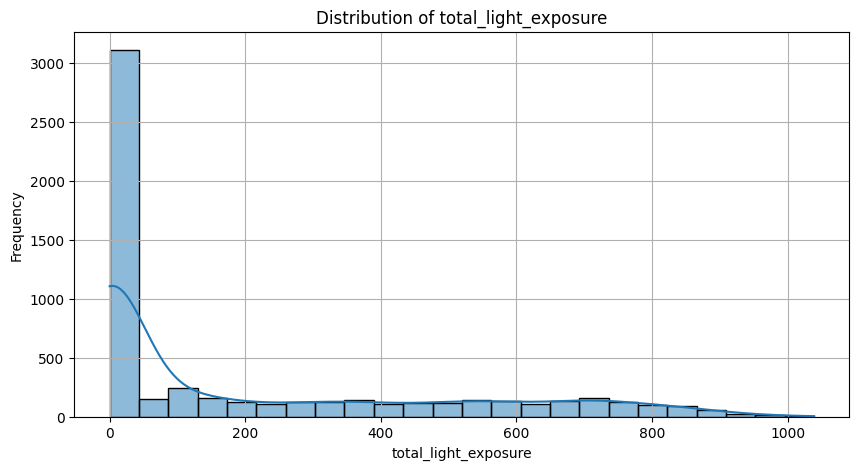

count    5691.000000
mean      203.186610
std       279.081786
min         0.000000
25%         0.000000
50%         8.000000
75%       389.500000
max      1039.000000
Name: total_light_exposure, dtype: float64
Target Skewness: 1.100
Target variable is significantly skewed. Consider transformations (e.g., log) if model assumptions require it (less critical for trees).


In [36]:
# Ensure df_train and numerical_features are defined from the previous cell
if 'df_train' not in locals() or 'numerical_features' not in locals():
     raise NameError("df_train or numerical_features not defined. Run previous cells.")

# --- Target Distribution ---
print("\n--- Target Variable Distribution ---")
plt.figure(figsize=(10, 5))
sns.histplot(df_train[TARGET], kde=True)
plt.title(f'Distribution of {TARGET}')
plt.xlabel(TARGET)
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print(df_train[TARGET].describe())
# Check for skewness or outliers in the target
target_skew = df_train[TARGET].skew()
print(f"Target Skewness: {target_skew:.3f}")
if abs(target_skew) > 1:
    print("Target variable is significantly skewed. Consider transformations (e.g., log) if model assumptions require it (less critical for trees).")

In [ ]:
df['log_total_light_exposure'] = np.log1p(df['total_light_exposure'])

AttributeError: module 'numpy' has no attribute 'log2p'

In [34]:
df['total_light_exposure']

0         0.0
1         0.0
2        13.0
3       155.0
4         0.0
        ...  
6562      0.0
6563    514.0
6564    692.0
6565      0.0
6566      0.0
Name: total_light_exposure, Length: 6567, dtype: float64

In [32]:
x_kembali = np.expm1(df['log_total_light_exposure']) 

In [33]:
x_kembali

0         0.0
1         0.0
2        13.0
3       155.0
4         0.0
        ...  
6562      0.0
6563    514.0
6564    692.0
6565      0.0
6566      0.0
Name: log_total_light_exposure, Length: 6567, dtype: float64


--- Correlation with Target ---
Top 15 Positive Correlations:
total_light_exposure              1.000000
blue_light_penetration            0.997171
downwelling_light                 0.954451
thermal_emissions                 0.920481
perpendicular_light_intensity     0.894569
photoperiod_intensity             0.849273
water_temperature_50m             0.845019
scattered_light                   0.802633
dissolved_gas_pressure            0.788800
perceived_water_density           0.781251
salinity_50m                      0.747845
sediment_temperature_0_to_10cm    0.745265
is_photic_zone                    0.718976
current_turbulence                0.704342
partial_pressure_CO2 (µatm)       0.665005
current_velocity_near_surface     0.448398
Name: total_light_exposure, dtype: float64

Top 15 Negative Correlations:
microplankton_density                          -0.040659
sediment_porosity_30_to_100cm                  -0.043339
sediment_temperature_10_to_30cm                -0.068578
meso

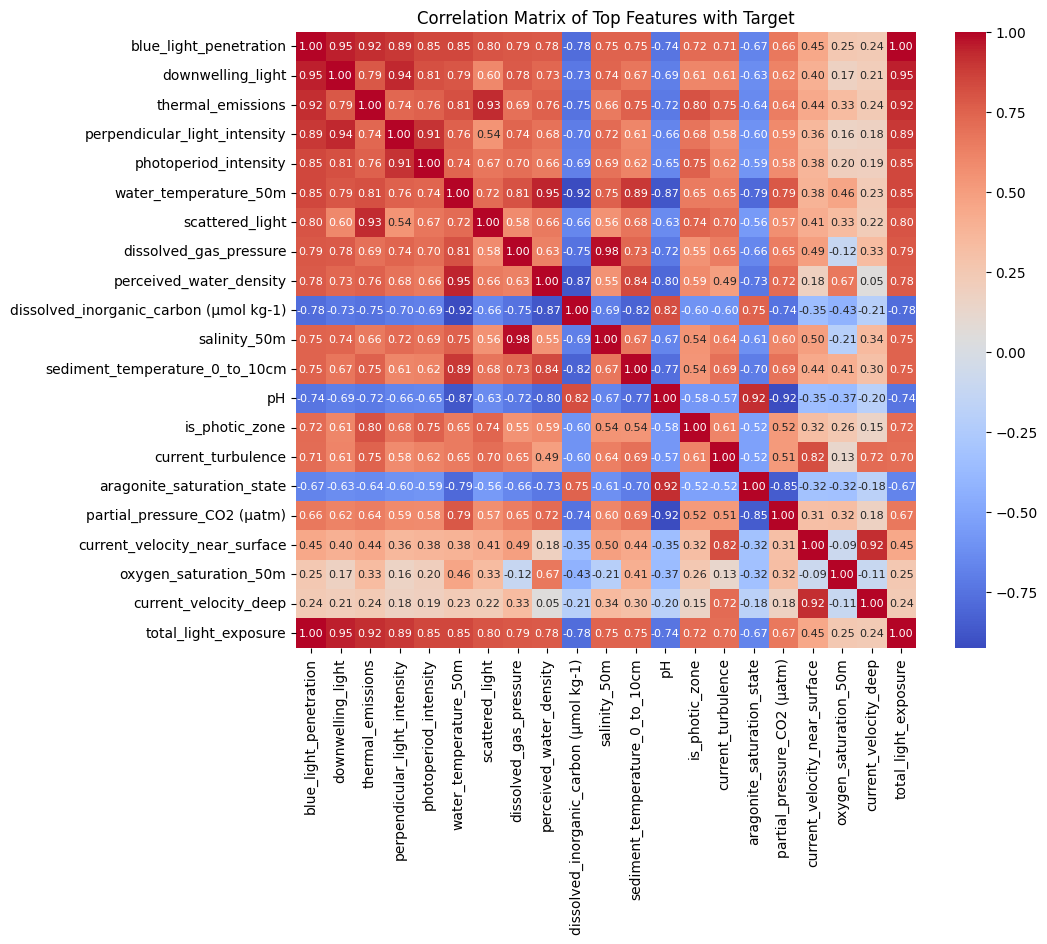

In [21]:
# --- Feature Correlations with Target ---
print("\n--- Correlation with Target ---")
# Ensure target is numeric before correlation calculation
if not pd.api.types.is_numeric_dtype(df_train[TARGET]):
    df_train[TARGET] = pd.to_numeric(df_train[TARGET], errors='coerce')
    print(f"Target NaNs after coercion: {df_train[TARGET].isnull().sum()}")
    # Optional: Drop rows where target became NaN
    # df_train.dropna(subset=[TARGET], inplace=True)

# Recalculate correlations only on numeric types, including the target
numeric_df_train = df_train.select_dtypes(include=np.number)

if TARGET in numeric_df_train.columns:
    correlations = numeric_df_train.corr()[TARGET].sort_values(ascending=False)
    print("Top 15 Positive Correlations:")
    print(correlations.head(16)) # includes target itself (corr=1)
    print("\nTop 15 Negative Correlations:")
    print(correlations.tail(15))

    # Plot top correlated features
    plt.figure(figsize=(10, 8))
    top_corr_features = correlations.abs().sort_values(ascending=False).index[1:21] # Top 20 excluding target
    sns.heatmap(numeric_df_train[top_corr_features].join(numeric_df_train[TARGET]).corr(),
                annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 8})
    plt.title('Correlation Matrix of Top Features with Target')
    plt.show()
else:
    print(f"Target '{TARGET}' not found or not numeric in df_train for correlation analysis.")

In [27]:
# --- Multicollinearity Check (VIF) ---
# VIF calculation can be computationally expensive on many features.
# Consider sampling or calculating on a subset of highly correlated features first.
print("\n--- Multicollinearity Check (VIF) ---")

# Select only numerical features used for modeling (already scaled)
# Exclude features with zero variance if any resulted from scaling/imputation
X_vif = df_train[features].copy()
X_vif = X_vif.loc[:, X_vif.var() > 1e-6] # Keep features with non-near-zero variance

# Add constant for VIF calculation intercept
X_vif['intercept'] = 1 # statsmodels handles the constant automatically

if X_vif.empty or X_vif.shape[1] < 2:
     print("Not enough features with variance to calculate VIF.")
else:
    try:
        # Calculate VIF for each feature
        vif_data = pd.DataFrame()
        vif_data["feature"] = X_vif.columns
        # Handle potential perfect multicollinearity during calculation
        try:
             vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
        except Exception as e:
             print(f"Error calculating VIF, possibly due to perfect multicollinearity: {e}")
             # Fallback or skip VIF
             vif_data["VIF"] = np.nan # Mark as failed

        vif_data = vif_data.sort_values(by="VIF", ascending=False)

        print("Top 10 Highest VIF Scores:")
        print(vif_data.head(100))

        high_vif_threshold = 10 # Common threshold, can be adjusted (5-10)
        high_vif_features = vif_data[vif_data["VIF"] > high_vif_threshold]["feature"].tolist()

        if high_vif_features:
            print(f"\nFeatures with VIF > {high_vif_threshold}: {high_vif_features}")
            print("Consider removing some of these features, prioritizing those less correlated with the target,")
            print("or using models robust to multicollinearity (like tree ensembles with regularization).")
            # --- Strategy for removing high VIF features (Example - uncomment to use) ---
            # This requires careful consideration - don't remove features vital for prediction.
            # A common approach is to iteratively remove the feature with the highest VIF
            # and recalculate until all VIFs are below the threshold.
            features_to_keep = features.copy()
            for feature in high_vif_features:
            #     # Example: Remove if VIF > 10 AND correlation with target is relatively low (e.g., < abs(0.3))
            #     # Need the 'correlations' series calculated earlier
                if TARGET in correlations.index: # Check if correlations were calculated
                    corr_with_target = correlations.get(feature, 0) # Get correlation, default to 0 if not found
                    if feature in features_to_keep and (abs(corr_with_target) < 0.3 or abs(corr_with_target) > 0.7): # Example threshold
                        print(f"Potential candidate for removal (High VIF, Low Target Corr): {feature} (VIF: {vif_data[vif_data['feature']==feature]['VIF'].values[0]:.2f}, Target Corr: {corr_with_target:.2f})")
                        features_to_keep.remove(feature) # Uncomment to actually remove
                        print(f"Removed {feature} based on VIF and low target correlation.")
                    else:
                         print(f"Keeping {feature} despite high VIF due to higher target correlation ({corr_with_target:.2f}) or other reasons.")
                else:
                     print(f"Cannot check target correlation for {feature} to aid VIF removal decision.")
            numerical_features = features_to_keep # Update list if features were removed
            print(f"Final numerical features after VIF check: {len(numerical_features)}")
        else:
            print(f"\nNo features found with VIF > {high_vif_threshold}. Multicollinearity seems manageable.")

    except np.linalg.LinAlgError:
        print("VIF calculation failed due to singular matrix (perfect multicollinearity).")
        print("Identify and remove perfectly correlated features.")
        # Add code here to find perfectly correlated pairs if needed
        # corr_matrix = X_vif.corr().abs()
        # upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        # to_drop = [column for column in upper.columns if any(upper[column] == 1)]
        # print(f"Perfectly correlated features to consider removing: {to_drop}")
    except Exception as e:
        print(f"An unexpected error occurred during VIF calculation: {e}")


--- Multicollinearity Check (VIF) ---
Top 10 Highest VIF Scores:
                                         feature           VIF
54                                     intercept  1.548933e+07
24                        blue_light_penetration  1.695315e+02
46        light_attenuation_coefficient_Kd (m⁻¹)  1.048831e+02
25                             downwelling_light  1.019481e+02
0                          water_temperature_50m  8.766446e+01
3                        perceived_water_density  7.469200e+01
31          chlorophyll_a_concentration (mg m-3)  5.608173e+01
10                        dissolved_gas_pressure  4.901541e+01
1                                   salinity_50m  4.536080e+01
45                               turbidity (NTU)  3.641188e+01
28                             thermal_emissions  3.390918e+01
26                               scattered_light  3.375634e+01
27                 perpendicular_light_intensity  3.169928e+01
2                          oxygen_saturation_50m  2.

In [26]:
correlations

total_light_exposure                            1.000000
blue_light_penetration                          0.997171
downwelling_light                               0.954451
thermal_emissions                               0.920481
perpendicular_light_intensity                   0.894569
photoperiod_intensity                           0.849273
water_temperature_50m                           0.845019
scattered_light                                 0.802633
dissolved_gas_pressure                          0.788800
perceived_water_density                         0.781251
salinity_50m                                    0.747845
sediment_temperature_0_to_10cm                  0.745265
is_photic_zone                                  0.718976
current_turbulence                              0.704342
partial_pressure_CO2 (µatm)                     0.665005
current_velocity_near_surface                   0.448398
oxygen_saturation_50m                           0.251781
current_velocity_deep          